# **Projet Datamining Master IMSD 2019-2020**

## **Charger les modules**

In [7]:
#from utils_files import concat_from_folder
import pandas as pd
import random
#!pip install twint
import twint
import tweepy
from datetime import datetime
from collections import Counter
import re
import matplotlib.pyplot as plt
import seaborn as sns
#!pip install squarify
#!pip install plotly
import plotly
import squarify
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
#!pip install unidecode
import unidecode
from textblob import TextBlob
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize 
nltk.download('punkt')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import classification_report, adjusted_rand_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## **Collection des données**

In [0]:
# COLLECTE DES TWEETS
candidates = [
    'agnesbuzyn', 'belliard',
    'datirachida', 'hidalgo',
    'villaniCedric']

other_belliard = [
    'aminataniakate', 'antoinetteguhl',
    'anneclaire_boux', 'danlert',
    'annesouyris']

other_buzyn = [
    'CatherineIbled', 'f_calandra',
    'pybournazel', 'olivier_rouxel',
    'chang_hua']

other_dati = [
    'AgnesEvren', 'fmdidier',
    'rudolphgranier', 'MarieToubiana',
    'geoffroyboulard'] #boulard = 17 car par de compte pour celui du 13 (Jean-Baptiste Olivier)

other_hidalgo = [
    'AnouchToranian', 'EricPliez',
    'EricLejoindre', 'FrancoisDagnaud',
    'jerome_coumet']

other_villani = [
    'geraud_guibert', 'Rayan_Nezzar',
    'lucaselalouf1', 'PaulaForteza',
    'AmirBenMerzoug']

def statuses_list(liste):

    for i in liste:
        c = twint.Config()
        c.Username = i
        c.Since = "2019-01-01 00:00:00"
        c.Store_csv = True
        c.Output = f"datasets\other_candidates\{i}.csv"
        twint.run.Search(c)

# exemple pour une liste
df_other_CANDIDATE = concat_from_folder(
    r'datasets\other_candidates\CANDIDATE',
    '/*.csv',
    r'datasets\other_candidates\df_other_CANDIDATE.p'
)

group_name = {
    'hidalgo': 'paris_en_commun',
    'dati' : 'engages_pour_sauver_paris',
    'belliard' : 'lecologie_pour_paris',
    'buzyn' : 'paris_ensemble',
    'villani' : 'le_nouveau_paris'
}

# exemple
df['parti_politique'] = group_name['buzyn']

# concatenation de tous les datasets
df_other_all = concat_from_folder(
    r'datasets\other_candidates',
    './*.p',
    r'datasets\other_candidates\df_other_all.p')

# COLLECTE DES 300 usernames

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)

liste = []
for user in tweepy.Cursor(api.followers, screen_name="David_Belliard").items():
    print('follower: ' + user.screen_name)
    liste.append(user.screen_name)
    print(len(liste))
    if len(liste) > 3000:
        break
    else:
        continue

df = pd.DataFrame(liste)
df.to_pickle(r'datasets\followers\followers_belliard.p')

# COLLECTE DES INFORMATIONS RELATIVES A CES 3000 COMPTES

df = pd.read_pickle(
    r'datasets\followers\followers_belliard.p')
df['names'] = df.values
ppl = df['names'].tolist()

for i in ppl:
    try:
        c = twint.Config()
        c.Username = i
        c.Store_csv = True
        c.Output = r'datasets\followers_users\belliarddf.csv'
        twint.run.Lookup(c)
    except:
        pass

#### **Importation des données**

In [21]:
from google.colab import files
uploaded = files.upload()

Saving agnesbuzyn.csv to agnesbuzyn (1).csv
Saving belliard.csv to belliard (1).csv
Saving datirachida.csv to datirachida (1).csv
Saving df_etat_des_lieux.p to df_etat_des_lieux (1).p
Saving df_nlp.p to df_nlp (2).p
Saving hidalgo.csv to hidalgo.csv
Saving users.p to users.p
Saving villaniCedric.csv to villaniCedric.csv


# **Partie 1 : Etude sur les followers**

In [0]:
def drop_dup(df,col_dup,col_nan,col_date,output):
  
    new_df = df.drop_duplicates(col_dup)
    new_df = new_df[new_df.bio.notna()]
    new_df['date'] = pd.to_datetime(new_df[col_date])
    new_df['nb_days'] =  datetime.now() - new_df.date
    new_df['nb_days'] = new_df.nb_days.apply(
        lambda x: x.days)
    new_df['ratio_tweets_days'] = round(
        new_df.tweets / new_df.nb_days, 4)
    new_df.to_pickle(output)
    return new_df

def hashtags_bio(DataFrame, col, nb):
    """
    Function to get hashtags from a twitter bio
    
    Arguments:
        DataFrame {DataFrame} -- df to use
        col {str} -- column's name
        nb {int} -- number of words
    
    Returns: [DataFrame] 

    Exemple:
        print(hashtags_bio(df_u, 'bio', 10))
    """

    df = DataFrame
    m1 = [
        item.lower() for i in DataFrame[col].tolist()
        for item in i.split() if re.findall(
            r"(\#[a-zA-Z0-9]+\b)", item)]
    c1 = Counter(m1)
    data = c1.most_common(nb) 
    df = pd.DataFrame(data, columns=['hashtag', 'number'])
    return df

def profiling(
        followers,
        profiles):
    dz = {}
    for p in profiles.keys():
        dz[p] = followers[followers.bio.str.contains(
                r'|'.join(profiles[p]), 
                case=False
            )].sort_values(
                'followers', 
                ascending=False
            )[[
                'username',
                'bio',
                'followers',
                'following'
            ]]
    return dz

In [0]:
# PREPROCESSING (exemple)
buzyn = drop_dup(buzyn, 'name', 'bio', 'join_date', r'C:\Users\lahat\Documents\M2IMSD\Data Mining\buzyn_no_dup.p')
buzyn = pd.read_pickle(r'C:\Users\lahat\Documents\M2IMSD\Data Mining\buzyn_no_dup.p')
bu = pd.read_csv('agnesbuzyn.csv')

In [0]:
all_candidates = [buzyn, belliard, dati, hidalgo, villani]
''' Top hashtags '''
top_hash = []
for i in all_candidates:
    top_hash.append(hashtags_bio(i,'bio',20))
 
# exemple:
hash_buzyn = top_hash[0]
hash_buzyn.to_csv(r'datasets\results\hash_buzyn.csv')

''' Nombre followers moyen + verified '''
verified = []
mean_followers = []
median_followers = []
ratio_tweets_day_mean = []
ratio_tweets_day_median = []
for i in all_candidates:
    verified.append(sum(i.verified))
for i in all_candidates:
    mean_followers.append(round(i.followers.mean(),4))
for i in all_candidates:
    ratio_tweets_day_mean.append(round(i.ratio_tweets_days.mean(), 4))
for i in all_candidates:
    median_followers.append(round(i.followers.median(),4))
for i in all_candidates:
    ratio_tweets_day_median.append(round(i.ratio_tweets_days.median(), 4))

''' Profiling followers '''
clus = {
    "politique": [
        "député",
        "députée",
        "sénateur",
        "sénatrice",
        "ministre",
        "maire",
        "secrétaire d\'Etat",
        "secrétaire d\'État",
        "parlementaire",
        "député européen",
        "conseil régional",
        "conseiller régional"
    ],
    "entrepreneur" : [
        "entrepreneur",
        "entreprenor",
        "chairman",
        "co-founder",
        "cofounder",
        "founder",
        "owner",
        "emprendedor",
        "bauunternehmen",
        "unternehmen", 
        "baufirma",
        "bauunternehmer",
        "unternehmer",
        "empreiteiro", 
        "empreendedor",
        "impresario",
        "appaltatore"
    ],
    "journalistes" : [
        "journaliste",
        "journalist",
        "éditorial",
        "editor",
        "rédacteur",
        "giornalista",
        "reporter",
        "inviato",
        "reporterin",
        "korrespondent",
        "korrespondentin",
        "repórter",
        "jornalista"
    ],
    "vc": [
        "venture",
        "capital",
        "président du directoire",
        "présidente du directoire",
        "president du directoire", 
        "presidente du directoire",
        "managing partner",
        "venture capitalist",
        "seed vc",
        "partner",
        "vc investor",
        "pe investor",
        "private equity",
        "early-stage",
        "general partner",
        "managing partner",
        "early stage",
        "pe investing",
        "business-angel",
        "business angel",
        "vc partner", 
        "vc firm",
        "pe firm",
        "investor",
        "investisseur",
        "invesor",
        "inversionista",
        "geldgeber",
        "kapitalanger",
        "investidor",
        "investitore"
    ],
    "etudiants": [
        "étudiant", 
        "etudiant",
        "student", 
        "estudiante",
    ]
}

# exemple:
profiling_buzyn = profiling(followers=buzyn, profiles=clus)
for p, df in profiling_buzyn.items():
    dz = pd.DataFrame(df)
    dz['bio'] = dz.bio.apply(
        lambda x: unidecode.unidecode(x))
    dz.to_csv(f'cluster_buzyn_{p}.csv')

# **Partie 2 : Etude sur les candidats**

# **Fichier USERS**

In [22]:
users = pd.read_pickle('users.p')
users.drop('index', axis=1, inplace=True)
users.head()

id  ...                                   background_image
0           305783924  ...  https://pbs.twimg.com/profile_banners/30578392...
1  864830560560132097  ...  https://pbs.twimg.com/profile_banners/86483056...
2           272401679  ...  https://pbs.twimg.com/profile_banners/27240167...
3            26073581  ...  https://pbs.twimg.com/profile_banners/26073581...
4  861942866989469697  ...  https://pbs.twimg.com/profile_banners/86194286...

[5 rows x 17 columns]

In [218]:
print(users.columns)
print(users.shape)

Index(['id', 'name', 'username', 'bio', 'location', 'url', 'join_date',
       'join_time', 'tweets', 'following', 'followers', 'likes', 'media',
       'private', 'verified', 'profile_image_url', 'background_image'],
      dtype='object')
(5, 17)


**Les colonnes à garder dans les fichiers "users"**

In [0]:
col_to_keep = ['id', 'name', 'username', 'bio', 'url', 'join_date', 'join_time', 'tweets', 'following', 
               'followers', 'likes', 'media', 'private', 'verified', 'profile_image_url', 'background_image']

users = users[col_to_keep]

In [220]:
users[["username","tweets"]]

username  tweets
0  David_Belliard   13022
1      agnesbuzyn    2656
2     datirachida    4761
3    Anne_Hidalgo   98833
4   VillaniCedric    2372

# **Etat des lieux**

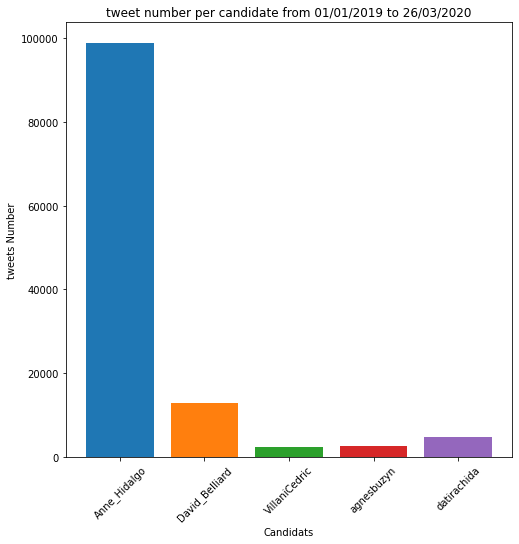

In [222]:
def tweetCand(df):
  
  groups = df.groupby('username')

  plt.figure(figsize=(8,8))
  for name, group in groups:
    
    plt.bar(name, group['tweets'], align='center')
    plt.xticks(rotation=45) 
    plt.title("tweet number per candidate from 01/01/2019 to 26/03/2020")
    plt.xlabel("Candidats")
    plt.ylabel("tweets Number")
  plt.show()

tweetCand(users)

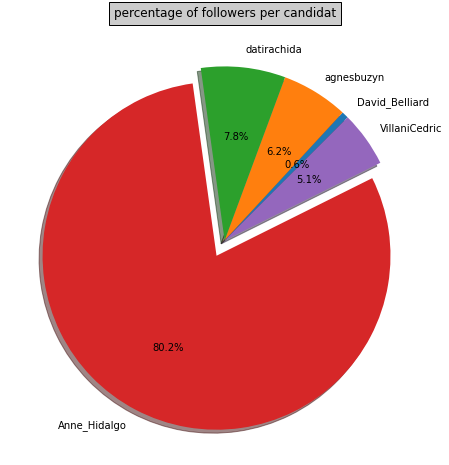

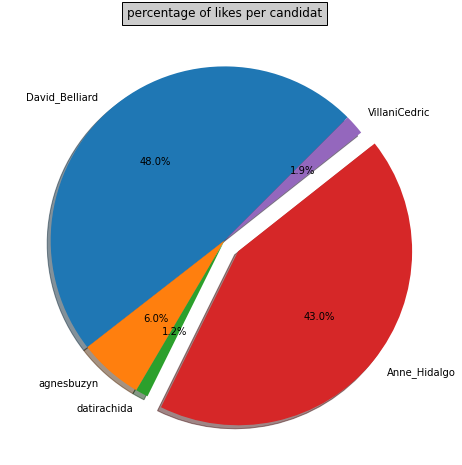

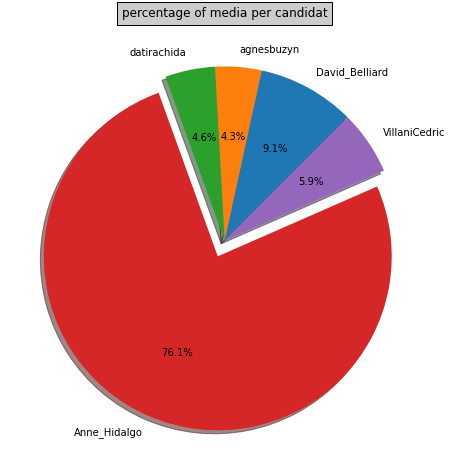

In [223]:
def cand(df):

    for i in df[['followers', 'likes', 'media']]:
        plt.figure(1,figsize=(8, 8))
        explode=(0, 0, 0, 0.1 , 0)
        plt.pie(x=df[i], labels=df['username'], explode=explode,
                autopct='%1.1f%%', shadow=True, startangle=45)
        plt.title("percentage of" + " " + i + " " + "per candidat", bbox={'facecolor':'0.8', 'pad':5})
        plt.show()
        
cand(users)

# **Fichier df_etat_des_lieux**

In [224]:
df_etat_des_lieux = pd.read_pickle('df_etat_des_lieux.p')
df_etat_des_lieux.drop('index', axis=1, inplace=True)
df_etat_des_lieux.head(3)

id      conversation_id  ...  trans_dest       parti_politique
0  1242927336825262081  1242927336825262081  ...         NaN  lecologie_pour_paris
1  1242778644839305216  1242778644839305216  ...         NaN  lecologie_pour_paris
2  1242720362653265920  1242720362653265920  ...         NaN  lecologie_pour_paris

[3 rows x 35 columns]

**Nombre de colonnes et de lignes du fichier df_etat_des_lieux**

In [226]:
print(df_etat_des_lieux.shape)

(8228, 35)


##### **Supprimer les infos liées au Covid19**

In [227]:
df_etat_des_lieux = df_etat_des_lieux[~((df_etat_des_lieux['tweet'].str.contains('virus', case=False, na=False)) | 
                                        (df_etat_des_lieux['tweet'].str.contains('covid', case=False, na=False))  |
                                        (df_etat_des_lieux['tweet'].str.contains('pandémie', case=False, na=False)) |
                                        (df_etat_des_lieux['tweet'].str.contains('epidemie', case=False, na=False)) |
                                        (df_etat_des_lieux['tweet'].str.contains('wuhan', case=False, na=False)) |
                                        (df_etat_des_lieux['tweet'].str.contains('confin', case=False, na=False)) |
                                        (df_etat_des_lieux['tweet'].str.contains('crise sanitaire', case=False, na=False)) |
                                        (df_etat_des_lieux['tweet'].str.contains('corona', case=False, na=False)))] 
df_etat_des_lieux.shape

(8125, 35)

In [228]:
df_etat_des_lieux.columns

Index(['id', 'conversation_id', 'created_at', 'date', 'time', 'timezone',
       'user_id', 'username', 'name', 'place', 'tweet', 'mentions', 'urls',
       'photos', 'replies_count', 'retweets_count', 'likes_count', 'hashtags',
       'cashtags', 'link', 'retweet', 'quote_url', 'video', 'near', 'geo',
       'source', 'user_rt_id', 'user_rt', 'retweet_id', 'reply_to',
       'retweet_date', 'translate', 'trans_src', 'trans_dest',
       'parti_politique'],
      dtype='object')

In [229]:
df_etat_des_lieux.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8125 entries, 1 to 8227
Data columns (total 35 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               8125 non-null   int64  
 1   conversation_id  8125 non-null   int64  
 2   created_at       8125 non-null   int64  
 3   date             8125 non-null   object 
 4   time             8125 non-null   object 
 5   timezone         8125 non-null   object 
 6   user_id          8125 non-null   int64  
 7   username         8125 non-null   object 
 8   name             8125 non-null   object 
 9   place            57 non-null     object 
 10  tweet            8125 non-null   object 
 11  mentions         8125 non-null   object 
 12  urls             8125 non-null   object 
 13  photos           8125 non-null   object 
 14  replies_count    8125 non-null   int64  
 15  retweets_count   8125 non-null   int64  
 16  likes_count      8125 non-null   int64  
 17  hashtags      

## **Les colonnes à garder dans les fichiers "df_etat_des_lieux"**

In [0]:
col_to_keep = ['id', 'conversation_id', 'created_at', 'date', 'time', 'timezone', 'user_id', 'username', 'name', 'tweet', 'mentions',
               'urls', 'photos', 'replies_count', 'retweets_count', 'likes_count', 'hashtags', 'link', 'retweet', 'video', 'reply_to', 'parti_politique']

df_etat_des_lieux = df_etat_des_lieux[col_to_keep]

In [231]:
def col_format(df):
  
    df.id = df.id.astype(str)
    df.time = pd.to_datetime(df['time'].str.strip(), format='%H:%M:%S')
    df.rename({'username':'candidat'}, axis=1, inplace=True)
    return df.info()

col_format(df_etat_des_lieux)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8125 entries, 1 to 8227
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id               8125 non-null   object        
 1   conversation_id  8125 non-null   int64         
 2   created_at       8125 non-null   int64         
 3   date             8125 non-null   object        
 4   time             8125 non-null   datetime64[ns]
 5   timezone         8125 non-null   object        
 6   user_id          8125 non-null   int64         
 7   candidat         8125 non-null   object        
 8   name             8125 non-null   object        
 9   tweet            8125 non-null   object        
 10  mentions         8125 non-null   object        
 11  urls             8125 non-null   object        
 12  photos           8125 non-null   object        
 13  replies_count    8125 non-null   int64         
 14  retweets_count   8125 non-null   int64  

In [232]:
def parse_date(df):
    
    """
    Formating date and adding 3 columns:
    year, month, day
    
    Arguments:
        df {pd.DataFrame} -- DataFrame to analyze
        date_col {pd.Series} -- Series containing date
    """
    # import pandas as pd
    df['date'] = pd.to_datetime(df.date, format='%Y-%m-%d')
    df['day'] = df.date.dt.day
    df['month'] = df.date.dt.month
    df['year'] = df.date.dt.year
    df['year_month'] = pd.to_datetime(df.date).dt.to_period('M')
    df['month_year'] = df.date.apply(lambda x : x.strftime("%B-%Y"))
    df['year'] = df.date.apply(lambda x : x.strftime("%Y"))
    df['day_of_week'] = df['date'].dt.day_name()
    df['hour'] = pd.to_datetime(df['time']).dt.strftime('%H')
    return df.info()

parse_date(df_etat_des_lieux)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8125 entries, 1 to 8227
Data columns (total 29 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id               8125 non-null   object        
 1   conversation_id  8125 non-null   int64         
 2   created_at       8125 non-null   int64         
 3   date             8125 non-null   datetime64[ns]
 4   time             8125 non-null   datetime64[ns]
 5   timezone         8125 non-null   object        
 6   user_id          8125 non-null   int64         
 7   candidat         8125 non-null   object        
 8   name             8125 non-null   object        
 9   tweet            8125 non-null   object        
 10  mentions         8125 non-null   object        
 11  urls             8125 non-null   object        
 12  photos           8125 non-null   object        
 13  replies_count    8125 non-null   int64         
 14  retweets_count   8125 non-null   int64  

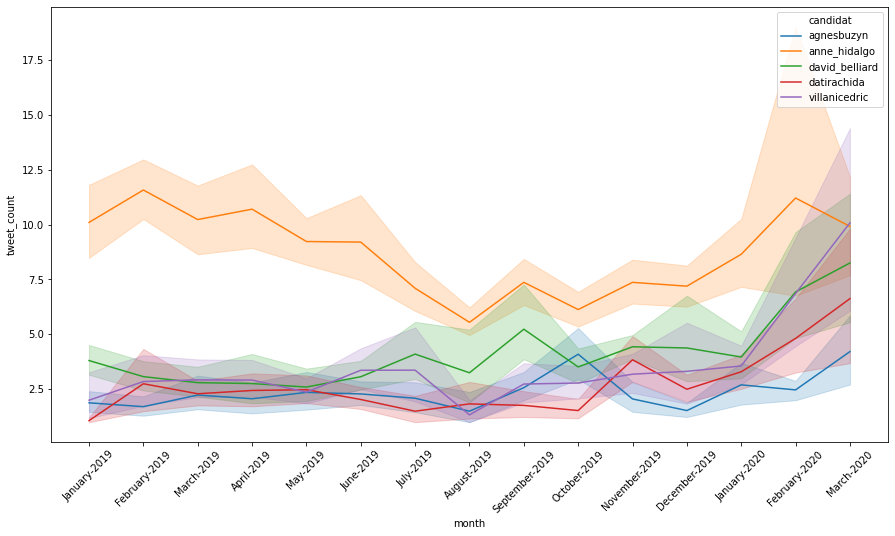

In [234]:
def publication_frequency(df):
    """
    Function to show monthly publication frequency of a 
    twitter account on a lineplot
    
    Arguments:
        df {DataFrame} -- DataFrame to analyze
    
    Returns:
        freq {pd.GroupBy} -- monthly pub frequency
        ax {AxesSubplot} -- visualization
    """
    
    df = pd.DataFrame(
        df.groupby(
            ["candidat", "month_year", "date", "year"])
            .size(), columns=["count"])
    df.reset_index(inplace=True)
    df.sort_values(by=['year','date'], inplace=True)

    # graph
    plt.figure(figsize=(15,8))
    ax = sns.lineplot(
        x="month_year", y='count',
        data=df, hue="candidat", sort=False)
    ax.set(
        xlabel='month', ylabel='tweet_count')
    plt.xticks(rotation=45)
    plt.show()

publication_frequency(df_etat_des_lieux)

#### **Plotting number of tweets per hour**

candidat  count
hour                       
00        agnesbuzyn      5
00      anne_hidalgo     31
00       datirachida      2
00    david_belliard     12
00     villanicedric     12

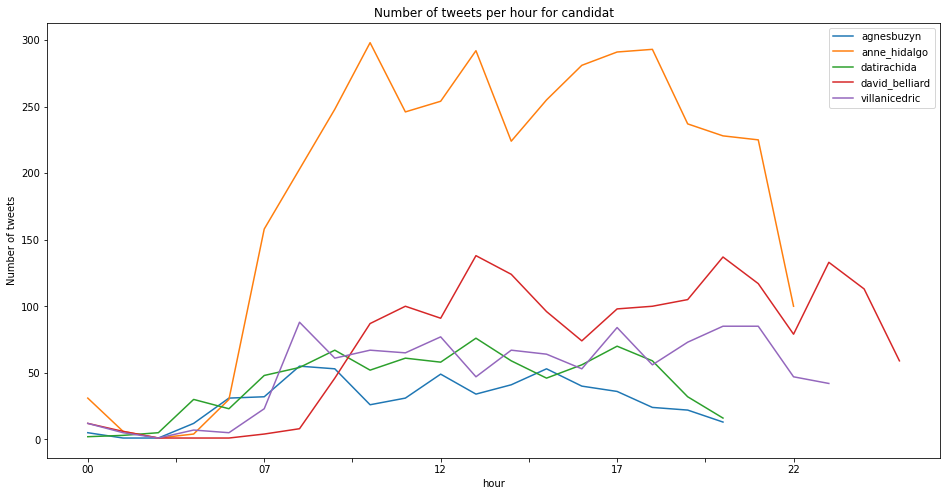

In [235]:
df_hour = df_etat_des_lieux[['hour', 'candidat']]
df_hour.head(3)

df_hour = pd.DataFrame(
        df_hour.groupby(
            ["hour", "candidat"])
            .size(), columns=["count"])

df_hour.reset_index(inplace=True)
df_hour.sort_values(by='hour', inplace=True)
df_hour.set_index('hour', inplace=True)
df_hour.groupby('candidat')['count'].plot(legend=True, figsize=(16, 8))
plt.ylabel("Number of tweets")
plt.title("Number of tweets per hour for candidat")
df_hour.head()

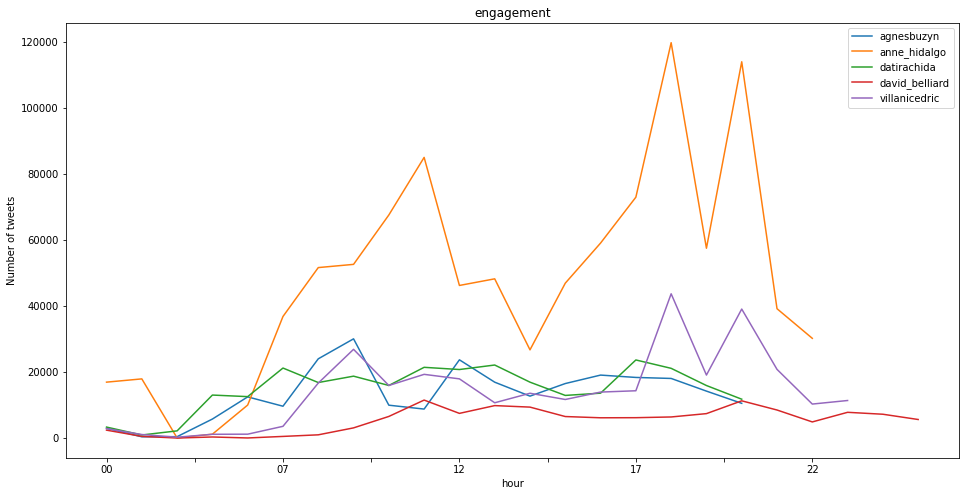

In [236]:
df_etat_des_lieux['eng'] = df_etat_des_lieux['replies_count'] + df_etat_des_lieux['retweets_count'] + df_etat_des_lieux['likes_count']
df_eng = df_etat_des_lieux[['hour','eng', 'candidat']]
df_eng.head(3)

df_eng = pd.DataFrame(
        df_eng.groupby(
            ["hour", "candidat"])
            .sum())
    
df_eng.reset_index(inplace=True)
df_eng.sort_values(by='hour', inplace=True)
df_eng.set_index('hour', inplace=True)
df_eng.groupby('candidat')['eng'].plot(legend=True, figsize=(16, 8))
plt.ylabel("Number of tweets")
plt.title("engagement")
plt.show()

#### **Number of tweets according per week**


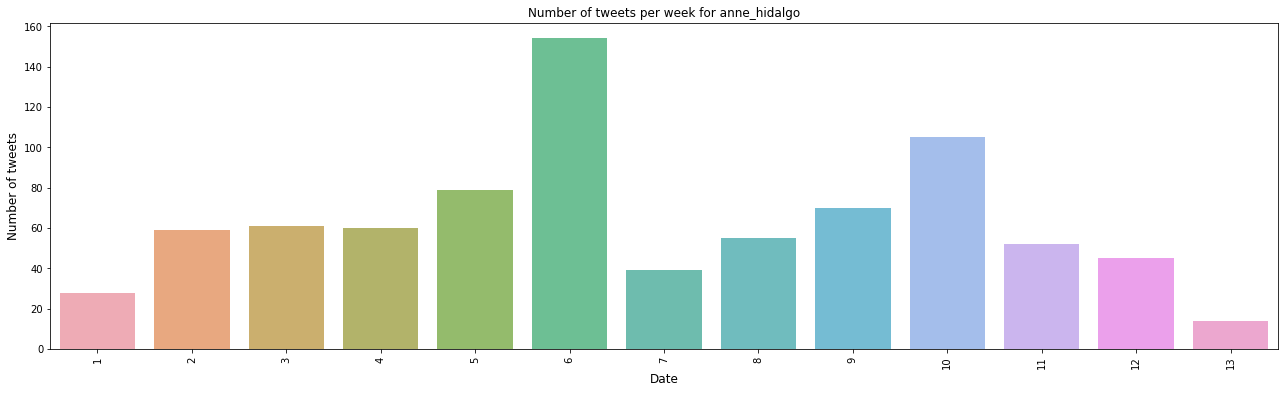

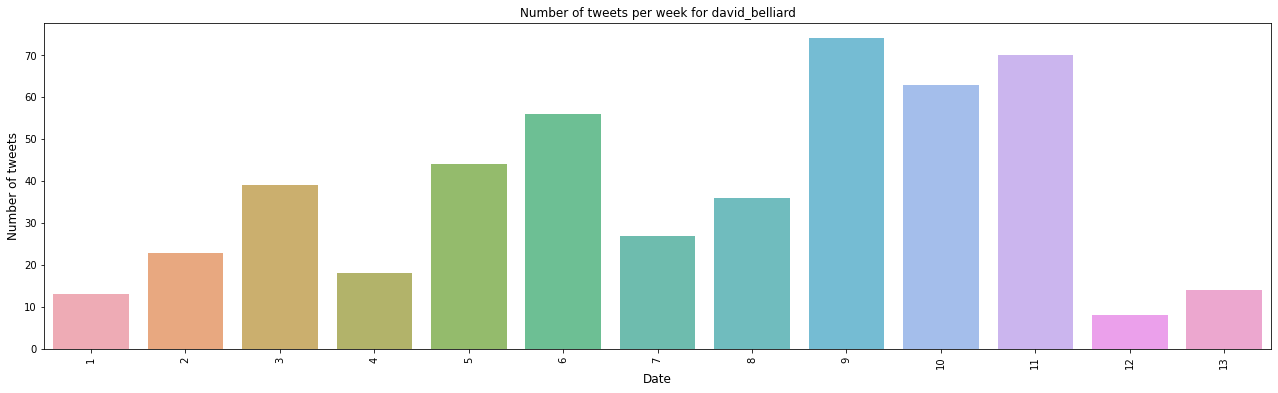

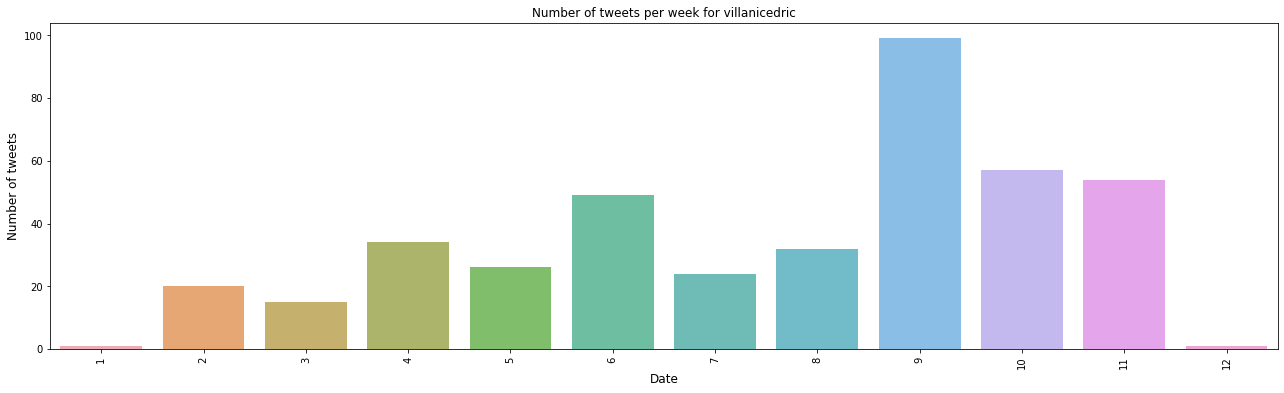

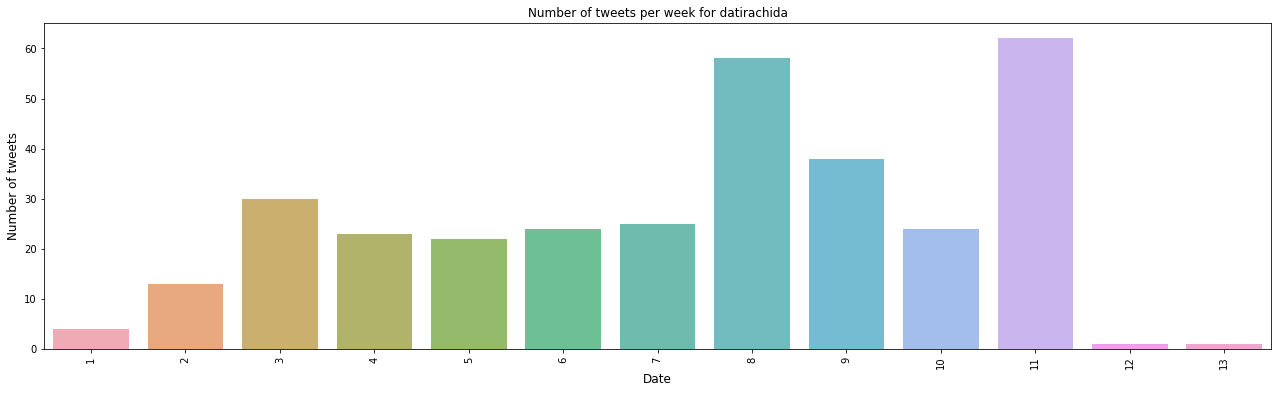

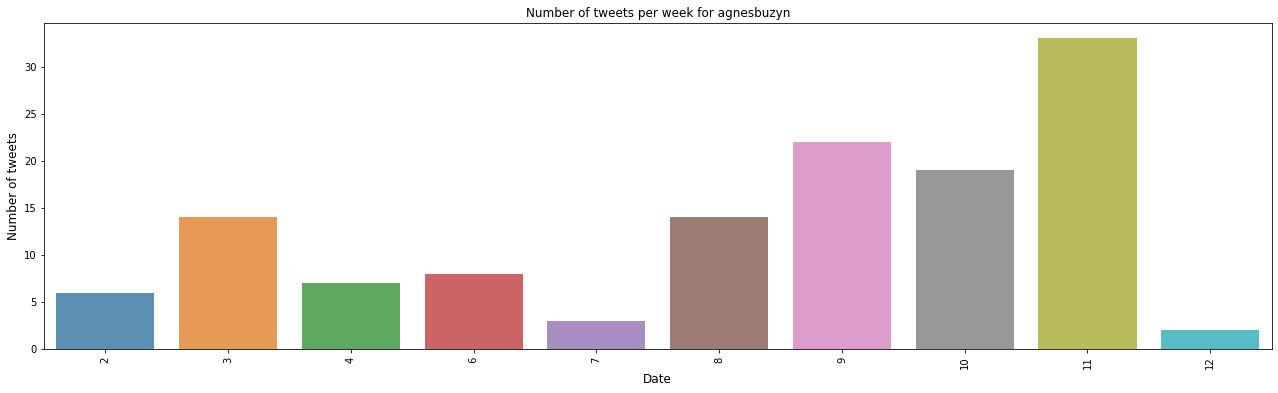

In [237]:
df_week = df_etat_des_lieux[df_etat_des_lieux["year"]=="2020"]
def tweet_weeks(df, col, date):

    for cand in ['anne_hidalgo', 'david_belliard', 'villanicedric', 'datirachida', 'agnesbuzyn']:
        tweet_cand = df[df[col]==cand]

        cnt_srs = tweet_cand[date].dt.week.value_counts()
        cnt_srs = cnt_srs.sort_index()
        plt.figure(figsize=(22,6))
        sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
        plt.xticks(rotation='vertical')
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Number of tweets', fontsize=12)
        plt.title("Number of tweets per week for" + " " + cand) 
        plt.show()

tweet_weeks(df_week, 'candidat', 'date')

### **Treemap of number of tweets by days of the week per candidat**

In [240]:
def tweet_days(df, col, date):

    for cand in ['anne_hidalgo', 'david_belliard', 'villanicedric', 'datirachida', 'agnesbuzyn']:

        tweet_day = df[df[col]==cand]

        x = 0.
        y = 0.
        width = 50.
        height = 50.
        type_list = list(tweet_day[date].unique())
        values = [len(tweet_day[tweet_day[date] == i]) for i in type_list]

        normed = squarify.normalize_sizes(values, width, height)
        rects = squarify.squarify(normed, x, y, width, height)

        color_brewer = ['#DFA215','#9CDF15','#15C0DF','#BD15DF','#EF8354','#969406','#1ABC9C']
        shapes = []
        annotations = []
        counter = 0

        for r in rects:
            shapes.append( 
                dict(
                    type = 'rect', 
                    x0 = r['x'], 
                    y0 = r['y'], 
                    x1 = r['x']+r['dx'], 
                    y1 = r['y']+r['dy'],
                    line = dict( width = 2 ),
                    fillcolor = color_brewer[counter]
                ) 
            )
            annotations.append(
                dict(
                    x = r['x']+(r['dx']/2),
                    y = r['y']+(r['dy']/2),
                    text = "{}-{}".format(type_list[counter], values[counter]),
                    showarrow = False
                )
            )
            counter = counter + 1
            if counter >= len(color_brewer):
                counter = 0

        # For hover text
        trace0 = go.Scatter(
            x = [ r['x']+(r['dx']/2) for r in rects ], 
            y = [ r['y']+(r['dy']/2) for r in rects ],
            text = [ str(v) for v in values ], 
            mode = 'text',
        )
                
        layout = go.Layout(
            title = go.layout.Title(text='Number of tweets by days of the week for' + ' ' + cand, font=dict(size=14, color='#000000')),
            height=700, 
            width=700,
            xaxis=dict(showgrid=False,zeroline=False),
            yaxis=dict(showgrid=False,zeroline=False),
            shapes=shapes,
            annotations=annotations,
            hovermode='closest',
            font=dict(color="#FFFFFF")
        )

        # With hovertext

        fig = go.Figure(data=[trace0], layout=layout)
        iplot(fig)

tweet_days(df_etat_des_lieux, 'candidat', 'day_of_week')

In [241]:
def extract_best_tweets_from_regex(df, regex):
  
    """
    Function allowing to extract the most engaging tweets
    based on a regex

    Arguments:
        df {pd.DataFrame} -- DataFrame to analyze
        regex {str} -- [description]
    
    Returns:
        df -- sorted (by engagement) DataFrame
        top_tweet -- list of most engaging twets urls
    
    Exemple:
        df, liste = extract_best_tweets_from_regex(df_s, "corona")
    """
    df['eng'] = df['replies_count'] + df['retweets_count'] + df['likes_count']
    df = df[df.tweet.str.contains(
        r'|'.join(regex), case=False)]
    df = df.sort_values(by=['eng'], ascending=False)
    top_tweet = df.link.tolist()
    
    return df, top_tweet

extract_best_tweets_from_regex(df_etat_des_lieux, "tweet")

(                       id      conversation_id  ...  hour    eng
 4411  1192898252116549632  1192898252116549632  ...    21  29902
 5989  1117868749644636160  1117868749644636160  ...    21  27866
 6364  1106266641103572992  1106266641103572992  ...    19  21666
 6135  1113025538631839747  1113025537453195264  ...    12  20999
 7592  1200098339145912320  1200098339145912320  ...    18  19812
 ...                   ...                  ...  ...   ...    ...
 1399  1123088396770004992  1122826986706087936  ...    06      0
 1729  1080931613389787137  1080924661658144769  ...    21      0
 666   1197630305995235328  1197458154465976321  ...    22      0
 1367  1127666994340401159  1127666713644937216  ...    22      0
 1517  1104866531714977793  1104772947749818368  ...    23      0
 
 [8096 rows x 30 columns],
 ['https://twitter.com/Anne_Hidalgo/status/1192898252116549632',
  'https://twitter.com/Anne_Hidalgo/status/1117868749644636160',
  'https://twitter.com/Anne_Hidalgo/status/110626

In [243]:
def hashtags_engagement(df):

    df = df[~df.retweet] 
    sn = df.iloc[0].candidat
    df = df.set_index(['id'])
    df['e'] = (
        df.replies_count +
        df.retweets_count +
        df.likes_count) 

    dz = (df['hashtags'].apply(pd.Series)
                              .stack()
                              .reset_index(level=1, drop=True)
                              .to_frame('hashtags')
                              .reset_index())

    dz.columns = ['id', 'hashtag']
    df = df.reset_index()
    df = df.merge(dz, on='id')

    dz = pd.DataFrame(
            df.groupby('hashtag')
                    .e.median()
                    .sort_values(ascending=False)
                    .head(10)
        ).reset_index()

    dz['merge_col'] = dz.index

    dz.columns = [
        'merge_col',
        sn + '_hashtags',
        sn + '_count'
    ]

    return dz
  
hashtags_engagement(df_etat_des_lieux)

merge_col  ...  david_belliard_count
0                     ['#brésil', '#lulalivre']  ...                     0
1  ['#ankara', '#istanbul', '#izmir', '#paris']  ...                     1
2                                   ['#càvous']  ...                     2
3                                ['#lulalibre']  ...                     3
4                          ['#mediatransports']  ...                     4
5                         ['#votapsoe', '#28a']  ...                     5
6       ['#paris', '#eurovision', '#votebilal']  ...                     6
7                               ['#bagelstein']  ...                     7
8                                ['#lulalivre']  ...                     8
9                ['#8mars', '#marchefeministe']  ...                     9

[10 rows x 3 columns]

In [244]:
def hashtags_text(DataFrame, col, nb):
    """
    Function to get hashtags from a twitter bio
    
    Arguments:
        DataFrame {DataFrame} -- df to use
        col {str} -- column's name
        nb {int} -- number of words
    
    Returns: [DataFrame] 

    Exemple:
        print(hashtags_bio(df_u, 'bio', 10))
    """

    df = DataFrame
    m1 = [
        item.lower() for i in DataFrame[col].tolist()
        for item in i.split() if re.findall(
            r"(\#[a-zA-Z0-9]+\b)", item)]
    c1 = Counter(m1)
    data = c1.most_common(nb)
    df = pd.DataFrame(data, columns=['hashtag', 'number'])
    return df


tweet_hastag = hashtags_text(df_etat_des_lieux, 'tweet', 50)
tweet_hastag.head()

hashtag  number
0          #paris     755
1      #paris2020     193
2  #ecologieparis     166
3  #datipourparis     166
4    #hidalgo2020     151

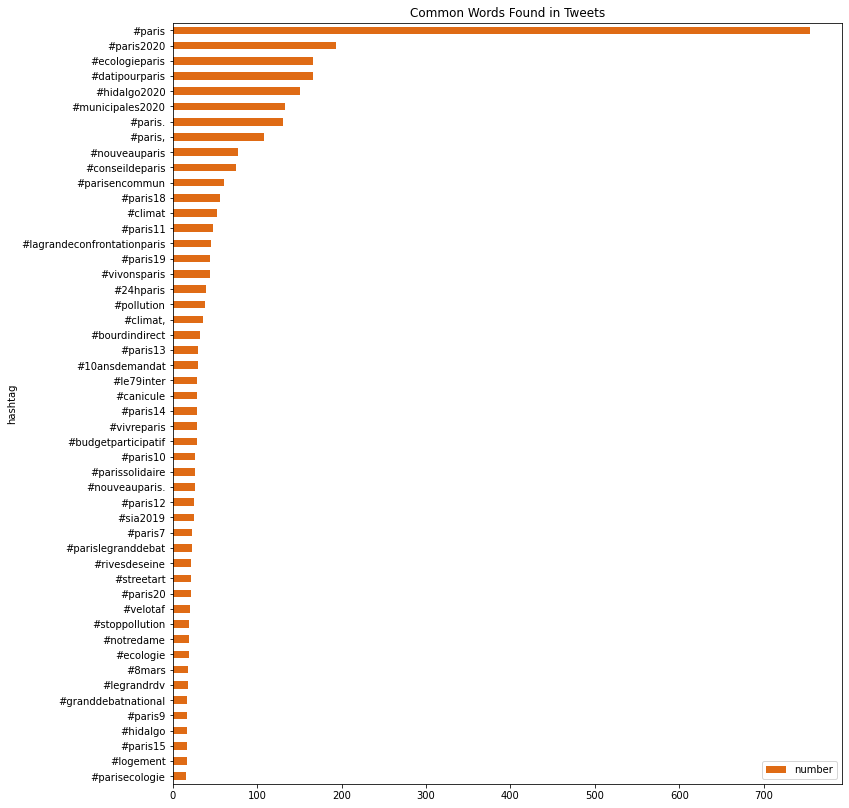

In [245]:
fig, ax = plt.subplots(figsize=(12, 14))
# Plot horizontal bar graph
tweet_hastag.sort_values(by='number').plot.barh(x='hashtag', y='number', ax=ax, color="#DF6B15")
ax.set_title("Common Words Found in Tweets")
plt.show()

# **Natural Language Processing**

# **Fichier df_nlp**

In [12]:
df_nlp = pd.read_pickle('df_nlp.p')
df_nlp.drop('level_0', axis=1, inplace=True)
df_nlp.drop('index', axis=1, inplace=True)
df_nlp.head()

id      conversation_id  ...  trans_dest       parti_politique
0  1242927336825262081  1242927336825262081  ...         NaN  lecologie_pour_paris
1  1242778644839305216  1242778644839305216  ...         NaN  lecologie_pour_paris
2  1242720362653265920  1242720362653265920  ...         NaN  lecologie_pour_paris
3  1242571174074335234  1242571174074335234  ...         NaN  lecologie_pour_paris
4  1242561747350884352  1242561729512509441  ...         NaN  lecologie_pour_paris

[5 rows x 35 columns]

In [13]:
df_nlp.shape

(22488, 35)

In [14]:
df_nlp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22488 entries, 0 to 22487
Data columns (total 35 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               22488 non-null  int64  
 1   conversation_id  22488 non-null  int64  
 2   created_at       22488 non-null  int64  
 3   date             22488 non-null  object 
 4   time             22488 non-null  object 
 5   timezone         22488 non-null  object 
 6   user_id          22488 non-null  int64  
 7   username         22488 non-null  object 
 8   name             22488 non-null  object 
 9   place            140 non-null    object 
 10  tweet            22488 non-null  object 
 11  mentions         22488 non-null  object 
 12  urls             22488 non-null  object 
 13  photos           22488 non-null  object 
 14  replies_count    22488 non-null  int64  
 15  retweets_count   22488 non-null  int64  
 16  likes_count      22488 non-null  int64  
 17  hashtags    

## **Les colonnes à garder dans les fichiers "df_nlp"**


In [0]:
col_to_keep = ["username", "tweet", "parti_politique"]
df_nlp = df_nlp[col_to_keep]
df_nlp.rename({'username':'candidat'}, axis=1, inplace=True)


In [16]:
df_nlp = df_nlp[~((df_nlp['tweet'].str.contains('virus', case=False, na=False)) | 
                 (df_nlp['tweet'].str.contains('covid', case=False, na=False))  |
                 (df_nlp['tweet'].str.contains('pandémie', case=False, na=False)) |
                 (df_nlp['tweet'].str.contains('epidemie', case=False, na=False)) |
                 (df_nlp['tweet'].str.contains('wuhan', case=False, na=False)) |
                 (df_nlp['tweet'].str.contains('confin', case=False, na=False)) |
                 (df_nlp['tweet'].str.contains('crise sanitaire', case=False, na=False)) |
                 (df_nlp['tweet'].str.contains('corona', case=False, na=False)))] 
df_nlp.shape

(21978, 3)

In [17]:
df_nlp.candidat.value_counts()

anne_hidalgo       3905
geoffroyboulard    2108
rayan_nezzar       1836
david_belliard     1730
jerome_coumet      1675
villanicedric      1114
francoisdagnaud     936
datirachida         817
f_calandra          759
paulaforteza        705
pybournazel         684
agnesevren          649
danlert             625
anneclaire_boux     564
agnesbuzyn          559
annesouyris         536
olivier_rouxel      433
ericlejoindre       426
antoinetteguhl      368
ericpliez           296
marietoubiana       236
anouchtoranian      173
rudolphgranier      168
aminataniakate      166
catherineibled      133
lucaselalouf1        93
fmdidier             79
geraud_guibert       78
amirbenmerzoug       68
chang_hua            59
Name: candidat, dtype: int64

## **Clean tweets**

In [18]:
to_remove=["a", "à demi", "à peine", "à peu près", "absolument","actuellement","ainsi","alors","apparemment","approximativement","après",
           "après-demain","assez","assurément","au","aucun","aucunement","aucuns","aujourd'hui","auparavant","aussi","aussitôt","autant",
           "autre","autrefois","autrement","avant","avant-hier","avec","avoir","beaucoup","bien","bientôt","bon","c'","ça","car",
           "carrément","ce","cela","celles","cependant","certainement","certes","ces","cet","cette","ceux","chaque","ci","comme","comment","complètement","d'",
           "d'abord","dans","davantage","de","début","dedans","dehors","déjà","demain","depuis","derechef","des","désormais","deux",
           "devrait","diablement","divinement","doit","donc","dorénavant","dos","droite","drôlement","du","elle","elles","en","en vérité",
           "encore","enfin","ensuite","entièrement","entre-temps","environ","essai","est","et","étaient","état","été","étions","être","eu",
           "extrêmement","fait","faites","fois","font","force","grandement","guère","habituellement","haut","hier","hors","ici","il","ils",
           "infiniment","insuffisamment","jadis","jamais","je","joliment","la","là","le","les","leur","leurs","lol","longtemps","lors","ma",
           "maintenant","mais","MDR","même","mes","moins","mon","mot","naguère","ne","ni","nommés","non","notre","nous","nouveaux","nullement",
           "ou","où","oui","par","parce","parfois","parole","pas","pas mal","passablement","personnes","peu","peut","peut-être","pièce","plupart",
           "plus","plutôt","point","pour","pourquoi","précisément","premièrement","presque","probablement","prou","puis","quand","quasi","quasiment",
           "que","quel","quelle","quelles","quelque","quelquefois","quels","qui","quotidiennement","rien","rudement","s'","sa","sans","sans doute",
           "ses","seulement","si","sien","sitôt","soit","son","sont","soudain","sous","souvent","soyez","subitement","suffisamment","sur","t'","ta",
           "tandis","tant","tantôt","tard","tellement","tellement","tels","terriblement","ton","tôt","totalement","toujours","tous","tout","tout à fait",
           "toutefois","très","trop","tu","un","une","valeur","vers","voie","voient","volontiers","vont","votre","vous","vraiment","vraisemblablement",
           'lot','amap','barr',"cher","e","camp","soi","ans","eme","des","min","tel","arc","min","cas","vel",
           "etc","sur","ept","tep","mme","ira","san","itw","rdv","mac","kgs","ouf","pdt","hey","bss","ask","puy","vge","vav","fcc",
           "dev","say","end","new","puc","mie","via","grs","rat","yes","las","los","fac","bav","nda","zep","pen",
           "hum","lie","chq","bro","pro","cad","bof","env","nes","cru","pre","pei","pls","pli","ehw","esj","xiv","ere","mou","pei",
           "duo","ehw","leo","bis","ing","day","hop","pop","pom","ame","hsf","ftm","add","mea","pvp","paf","rip","ivg","ten","prg","lfe","dej",
           "bcp","eua","mds","com","num","arr","fev","rep","pjl","fde","let","yun","por","ver","kit","key","www","sao",
           "nap","bhv","btw","ram","gif","iii","edl","ian","hub","pyb","pts","quo","qqs","kms","lin","ess","hab","way",
           "kms","lea","crc","plf","jdd"] 
           
def clean_tweets(tweet):

    tweet = tweet.lower()
    #Emoji patterns
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    tweet = emoji_pattern.sub(r'', tweet)# remove emoji

    tweet = re.sub("@[A-Za-z0-9]+", "", tweet)
    tweet = re.sub(r"(\#[a-zA-Z0-9]+\b)", '', tweet)
  
    tweet = re.sub(r"http\S+", "", tweet) # remove url
    tweet = re.sub(r"https?://[A-Za-z0-9./]+", "", tweet)      
    tweet = re.sub('pic.twitter.com\S+', "", tweet)

    tweet = re.sub('[^\w\s]', ' ',tweet)# remove puctuation

    stopw = stopwords.words('french') 
    tweet = ' '.join([word for word in tweet.split() if word not in (stopw)])
    stopw = stopwords.words('english') 
    tweet = ' '.join([word for word in tweet.split() if word not in (stopw)])
    tweet = ' '.join([word for word in tweet.split() if word not in (to_remove)])
    tweet = re.sub('[0-9]+', '', tweet) # remove number
    tweet = ' '.join([word for word in tweet.split() if not len(word)<=2])
    tweet = tweet.replace("aujourd hui", "aujourdhui")
    tweet = re.sub(r"_\S+", "", tweet)
    tweet = unidecode.unidecode(tweet) # remove accent
    tweet = ' '.join([word for word in tweet.split() if word not in (to_remove)])

    return tweet

df_nlp['tweet_without_stopwords'] = df_nlp['tweet'].apply(lambda x: clean_tweets(x))
df_nlp.head(3)
#df_nlp['tweet_without_stopwords'].to_list()

candidat  ...                            tweet_without_stopwords
1  david_belliard  ...  voitures air sain jour apporte preuves changer...
2  david_belliard  ...  crise traversons train rendre visibles ordinai...
3  david_belliard  ...  pretexte crise gouvernement demonte droit soci...

[3 rows x 4 columns]

In [19]:
def tokenization(text):
    text = re.split('\W+', text)
    return text

df_nlp['Tweet_tokenized'] = df_nlp['tweet_without_stopwords'].apply(lambda x: tokenization(x.lower()))
df_nlp.head()

candidat  ...                                    Tweet_tokenized
1  david_belliard  ...  [voitures, air, sain, jour, apporte, preuves, ...
2  david_belliard  ...  [crise, traversons, train, rendre, visibles, o...
3  david_belliard  ...  [pretexte, crise, gouvernement, demonte, droit...
4  david_belliard  ...  [alimentation, possibilite, approvisionner, pr...
5  david_belliard  ...  [peur, explosion, prix, penurie, alimentaire, ...

[5 rows x 5 columns]

In [20]:
ps = nltk.PorterStemmer()

def stemming(text):
    text = [ps.stem(word) for word in text]
    return text

df_nlp['Tweet_stemmed'] = df_nlp['Tweet_tokenized'].apply(lambda x: stemming(x))
df_nlp.head()

candidat  ...                                      Tweet_stemmed
1  david_belliard  ...  [voitur, air, sain, jour, apport, preuv, chang...
2  david_belliard  ...  [crise, traverson, train, rendr, visibl, ordin...
3  david_belliard  ...  [pretext, crise, gouvern, demont, droit, socia...
4  david_belliard  ...  [aliment, possibilit, approvisionn, produit, f...
5  david_belliard  ...  [peur, explos, prix, penuri, alimentair, super...

[5 rows x 6 columns]

# **Analyse sur les cinq premiers candidats**

In [254]:
df_cand = df_nlp[(df_nlp["candidat"]=="anne_hidalgo") | 
                 (df_nlp["candidat"]=="david_belliard")  |
                 (df_nlp["candidat"]=="villanicedric") | 
                 (df_nlp["candidat"]=="datirachida") |
                 (df_nlp["candidat"]=="agnesbuzyn")]
df_cand.candidat.value_counts()

anne_hidalgo      3905
david_belliard    1730
villanicedric     1114
datirachida        817
agnesbuzyn         559
Name: candidat, dtype: int64

#### **Print 100 most frequent words for each candidat**

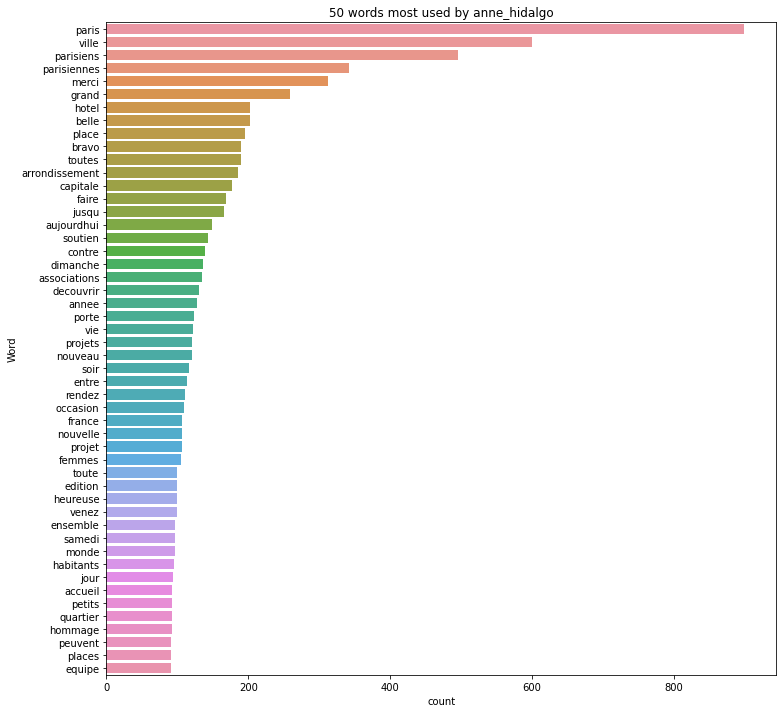

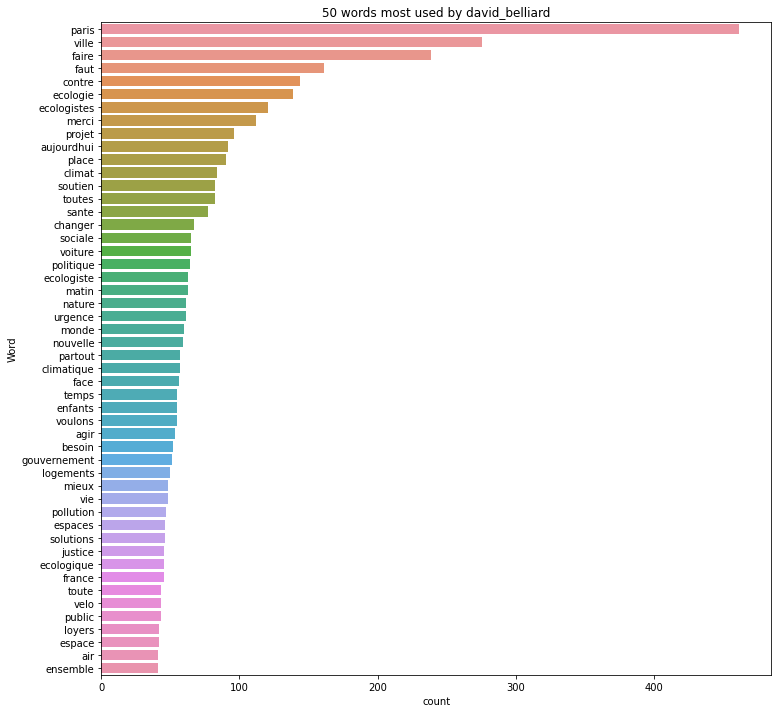

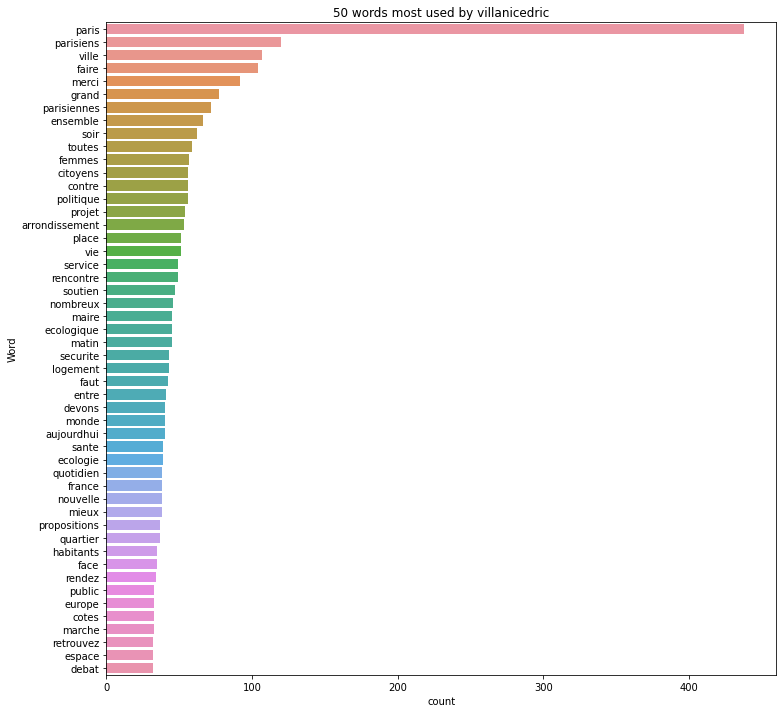

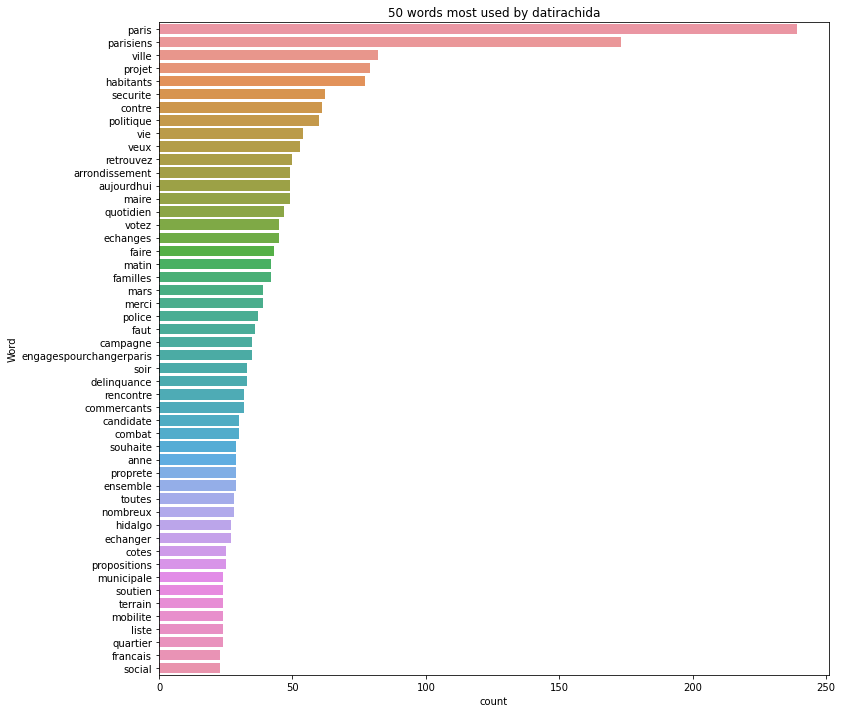

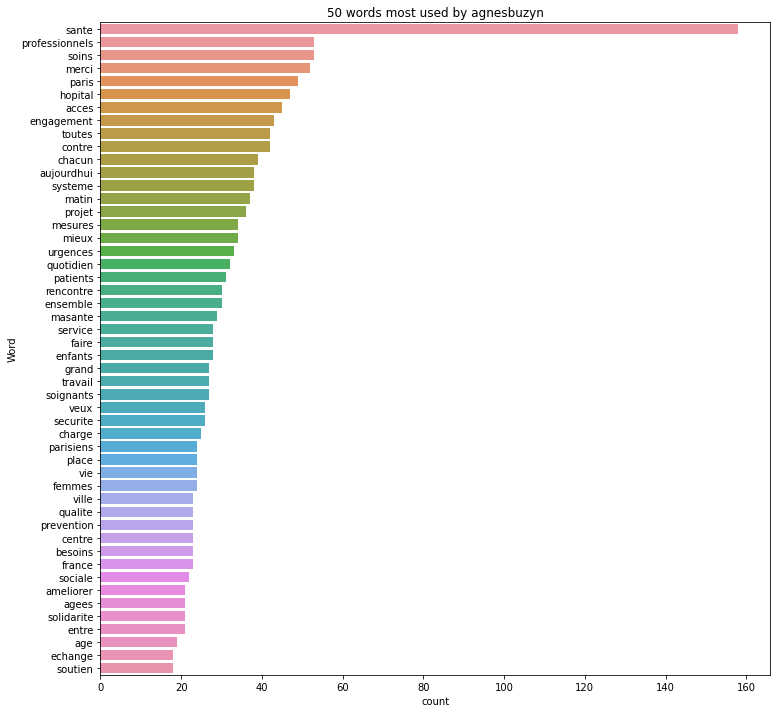

In [255]:
for cand in ['anne_hidalgo', 'david_belliard', 'villanicedric', 'datirachida', 'agnesbuzyn']:
      
      df = df_cand.loc[df_cand["candidat"].isin([cand]),:]
      all_words = ' '.join([text for text in df["tweet_without_stopwords"]]) 
      all_words = all_words.split() 
      fdist = nltk.FreqDist(all_words) 
      words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
      
      # selecting top 20 most frequent words 
      d = words_df.nlargest(columns="count", n = 50) 
      
      # visualize words and frequencies
      plt.figure(figsize=(12,12)) 
      ax = sns.barplot(data=d, x= "count", y = "word") 
      ax.set(ylabel = 'Word') 
      ax.set_title("50 words most used by" + ' ' + cand)
      plt.show() 


# **Sentiment Analysis**

In [257]:
df_cand['sentiment'] = df_cand['tweet_without_stopwords'].map(lambda text: TextBlob(text).sentiment.polarity)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [258]:
cut = pd.cut(
    df_cand['sentiment'],
    [-np.inf, -.01, .01, np.inf],
    labels=['negative', 'neutral', 'positive']
)
df_cand['polarity'] = cut.values
df_cand[['polarity','sentiment','candidat']][:10]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



polarity  sentiment        candidat
1    neutral   0.000000  david_belliard
2   positive   0.033333  david_belliard
3   positive   0.033333  david_belliard
4    neutral   0.000000  david_belliard
5    neutral   0.000000  david_belliard
6    neutral   0.000000  david_belliard
7   positive   0.150000  david_belliard
8    neutral   0.000000  david_belliard
9    neutral   0.000000  david_belliard
11   neutral   0.000000  david_belliard

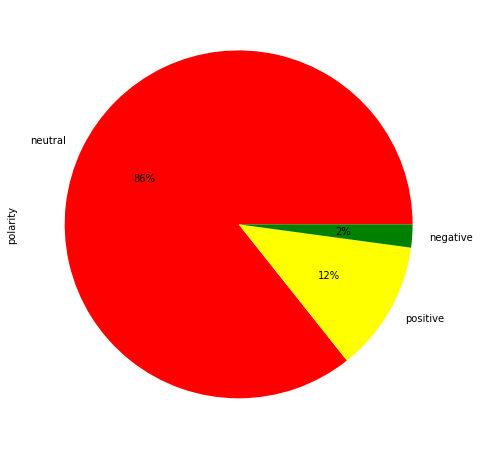

In [259]:
df_cand.polarity.value_counts().plot(kind='pie', autopct='%1.0f%%', figsize=(8, 8), colors=["red", "yellow", "green"])
plt.show()

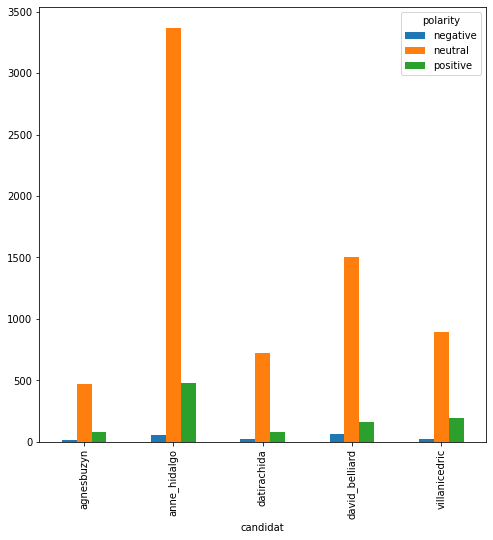

In [260]:
df_sentiment = df_cand.groupby(['candidat', 'polarity']).polarity.count().unstack()
df_sentiment.plot(kind='bar', figsize=(8, 8))
plt.show()

### **Print 100 most positive tweets for each candidat**

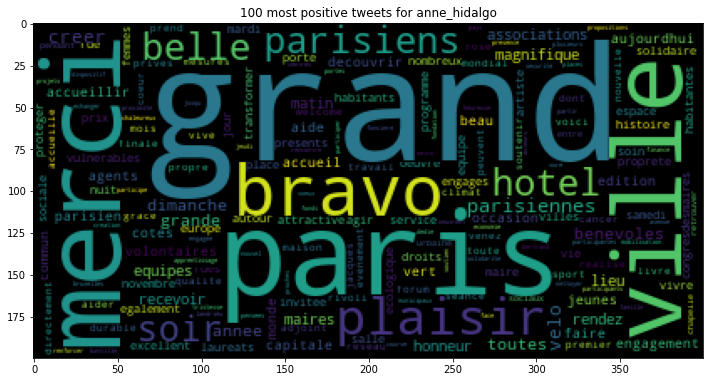

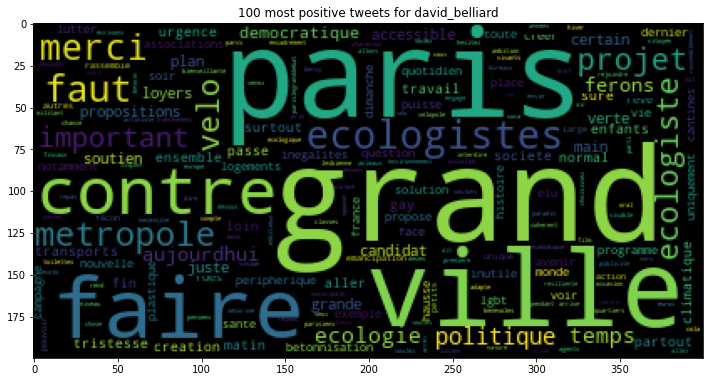

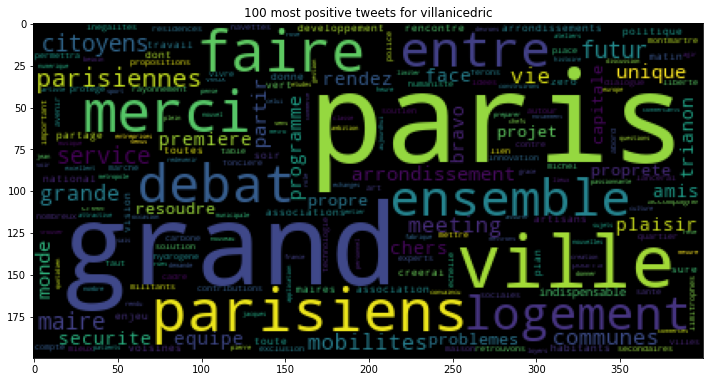

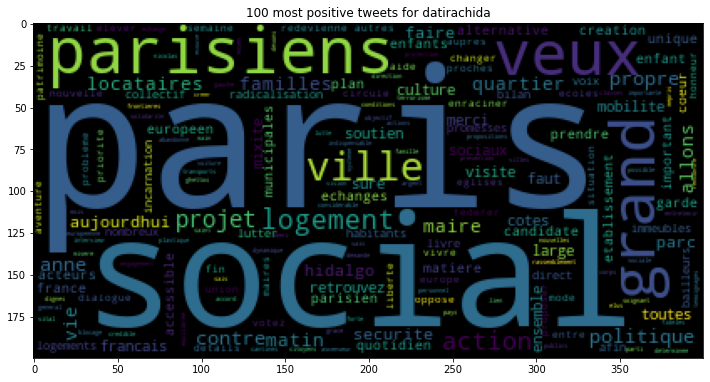

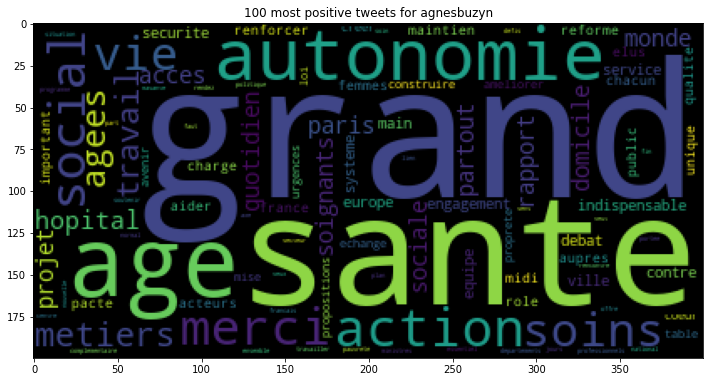

In [262]:
df = df_cand[['polarity','sentiment','candidat', 'tweet_without_stopwords']]

def nuage_mots(df, col, col_tweet, col_polarity, sentiment):

    for cand in ['anne_hidalgo', 'david_belliard', 'villanicedric', 'datirachida', 'agnesbuzyn']:
      
        text = df.loc[df[col].isin([cand]),:]
        text = text.sort_values(by=sentiment, ascending=False)
        text = text[text[col_polarity]=='positive']
        text = text.iloc[0:100,:]  

        text = text[col_tweet].str.cat(sep=' ')
        tokens = word_tokenize(text)
        freq_dist = nltk.FreqDist(tokens)

        # graph
        wordcloud = WordCloud().generate_from_frequencies(freq_dist)
        # Tracer le graphique
        fig = plt.figure(figsize = (12,8))
        ax = fig.add_subplot(111)
        ax.imshow(wordcloud)
        ax.set_title('100 most positive tweets for' + ' ' + cand)
        plt.show()

nuage_mots(df, "candidat", "tweet_without_stopwords", "polarity", "sentiment")

### **Print 100 most negative tweets for each candidat**

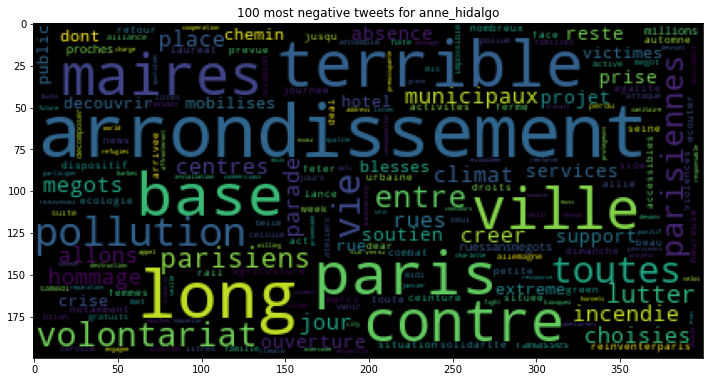

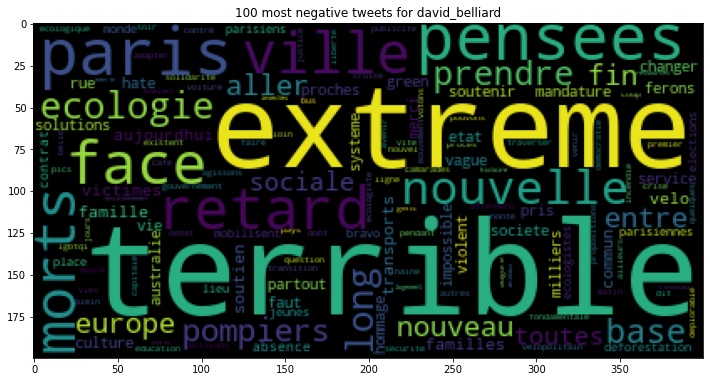

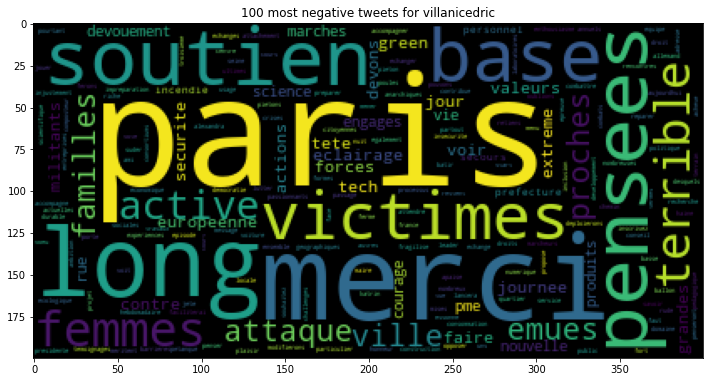

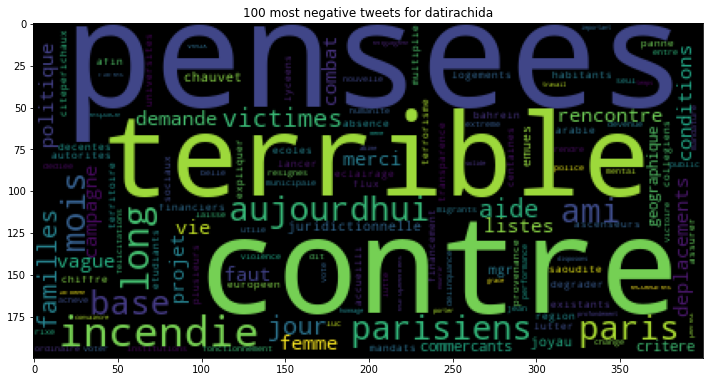

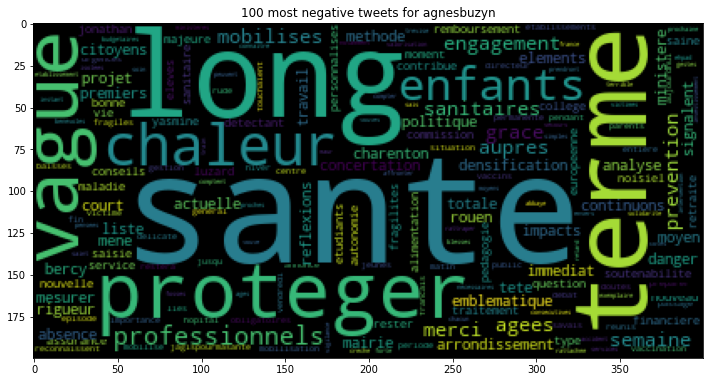

In [263]:
def nuage_mots(df, col, col_tweet, col_polarity, sentiment):

    for cand in ['anne_hidalgo', 'david_belliard', 'villanicedric', 'datirachida', 'agnesbuzyn']:
      
        text = df.loc[df[col].isin([cand]),:]
        text = text.sort_values(by=sentiment, ascending=False)
        text = text[text[col_polarity]=='negative']
        text = text.iloc[0:100,:]  

        text = text[col_tweet].str.cat(sep=' ')
        tokens = word_tokenize(text)
        freq_dist = nltk.FreqDist(tokens)

        # graph
        wordcloud = WordCloud().generate_from_frequencies(freq_dist)
        # Tracer le graphique
        fig = plt.figure(figsize = (12,8))
        ax = fig.add_subplot(111)
        ax.imshow(wordcloud)
        ax.set_title('100 most negative tweets for' + ' ' + cand)
        plt.show()

nuage_mots(df, "candidat", "tweet_without_stopwords", "polarity", "sentiment")

### **Print 100 most neutral tweets for each candidat**

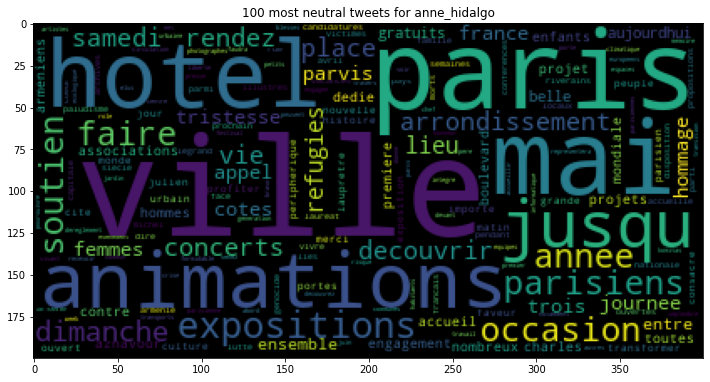

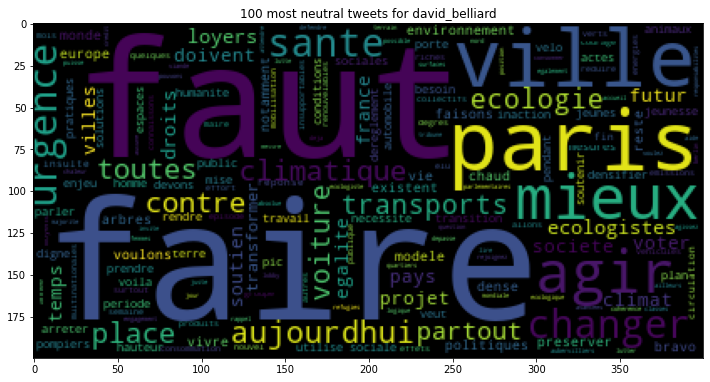

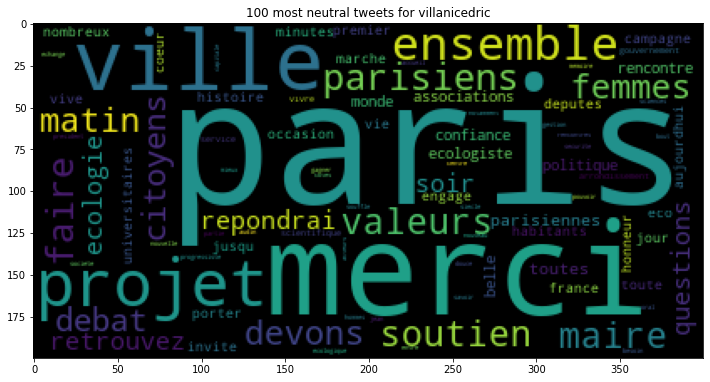

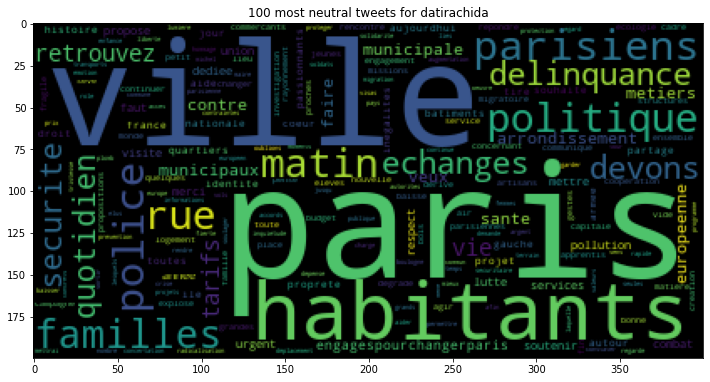

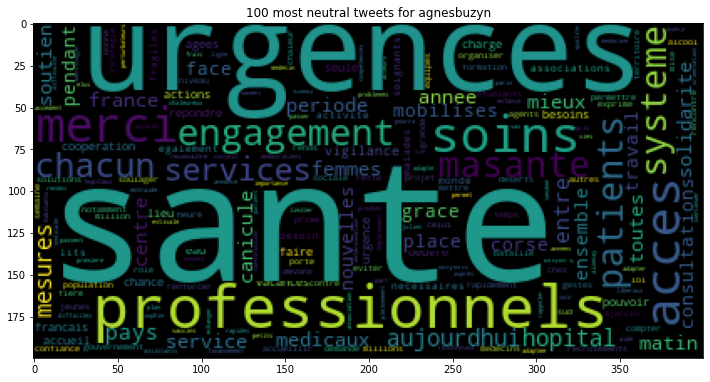

In [264]:
def nuage_mots(df, col, col_tweet, col_polarity, sentiment):

    for cand in ['anne_hidalgo', 'david_belliard', 'villanicedric', 'datirachida', 'agnesbuzyn']:
      
        text = df.loc[df[col].isin([cand]),:]
        text = text.sort_values(by=sentiment, ascending=False)
        text = text[text[col_polarity]=='neutral']
        text = text.iloc[0:100,:]  

        text = text[col_tweet].str.cat(sep=' ')
        tokens = word_tokenize(text)
        freq_dist = nltk.FreqDist(tokens)

        # graph
        wordcloud = WordCloud().generate_from_frequencies(freq_dist)
        # Tracer le graphique
        fig = plt.figure(figsize = (12,8))
        ax = fig.add_subplot(111)
        ax.imshow(wordcloud)
        ax.set_title('100 most neutral tweets for' + ' ' + cand)
        plt.show()

nuage_mots(df, "candidat", "tweet_without_stopwords", "polarity", "sentiment")

# **Linear Discriminant Analysis sur les cinq partis politiques**


In [0]:
paris_en_commun = df_nlp[df_nlp["parti_politique"]=="paris_en_commun"]
engages_pour_sauver_paris = df_nlp[df_nlp["parti_politique"]=="engages_pour_sauver_paris"]
lecologie_pour_paris = df_nlp[df_nlp["parti_politique"]=="lecologie_pour_paris"]
le_nouveau_paris = df_nlp[df_nlp["parti_politique"]=="le_nouveau_paris"]
paris_ensemble = df_nlp[df_nlp["parti_politique"]=="paris_ensemble"]

In [0]:
df_lda = df_nlp[df_nlp["parti_politique"]=="le_nouveau_paris"]

tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=1000)

def lda_partie_poitique(df):
  
    tfidf = tfidf_vectorizer.fit_transform(df["tweet_without_stopwords"])

    lda = LatentDirichletAllocation(n_components=6, max_iter=5,
                                    learning_method='online',
                                    learning_offset=50.,
                                    random_state=0)
    lda.fit(tfidf)
    tf_feature_names = tfidf_vectorizer.get_feature_names()

    def print_top_words(model, feature_names, n_top_words):
        for topic_idx, topic in enumerate(model.components_):
            print("Topic #%d:" % topic_idx)
            print(" ".join([feature_names[i]
                            for i in topic.argsort()[- n_top_words - 1:][::-1]]))
        
    print_top_words(lda, tf_feature_names, 10)

#### **paris_en_commun de anne_hidalgo**

In [269]:
lda_partie_poitique(paris_en_commun)

Topic #0:
belle jusqu rendez beau ville decouvrir mairie edition grand soir hotel
Topic #1:
paris vive solidarite partie passe famille republique proches jardins liste artiste
Topic #2:
quartier habitants rue initiative travaux belle inauguration merci social rencontre habitant
Topic #3:
merci bravo ecole soutien eleves enfants agents mairie parents equipes rentree
Topic #4:
paris contre faire ville police faut mieux parisiens face securite voici
Topic #5:
porte femmes situation refugies associations abri chapelle hommage italie place paris


### **engages_pour_sauver_paris de datirachida**

In [270]:
lda_partie_poitique(engages_pour_sauver_paris)

Topic #0:
ordre commission mettre vote accord verts temps europeenne place forces debat
Topic #1:
monde exposition bonne familles femmes lire sante politique sainte aide vernissage
Topic #2:
habitants paris parisiens projet rue quartier ville proprete arrondissement rencontre demande
Topic #3:
merci soutien police hommage contre victimes france signalement chere partir toutes
Topic #4:
retrouvez paris mars votez candidate interview venez actualite candidat dimanche choix
Topic #5:
bravo ecole presence merci rue habitants matin quartier belle soir elus


#### **lecologie_pour_paris de david_belliard**

In [271]:
lda_partie_poitique(lecologie_pour_paris)

Topic #0:
femmes violences sante vie contre affaire police aujourdhui liberte paris conditions
Topic #1:
merci ecologie soutien paris soir matin solidaire ecologistes solidarite toutes sociale
Topic #2:
porte mise dechets plastique politique place paris prochaine gouvernement source abri
Topic #3:
semaine votez article anti direct felicitations mars drogues heure montre soiree
Topic #4:
bravo marche elus alimentaire ordre quartier fetes equipe petits armes maintien
Topic #5:
paris ville faire contre enfants faut rue projet ecologistes sante pollution


#### **le_nouveau_paris de villanicedric**

In [272]:
lda_partie_poitique(le_nouveau_paris)

Topic #0:
soutien campagne chere effet politique reforme entre retraites liste juste systeme
Topic #1:
merci police moment faire france paris dit mois jour aujourdhui municipale
Topic #2:
paris europe citoyens politique projet parisiens numerique faire ville democratie nouveau
Topic #3:
prix propos jeu exprime moyenne retraite video intelligence etats millions petit
Topic #4:
soir invite plaisir partir debattre livre retrouvez questions meeting rendez inscriptions
Topic #5:
cedric villani bonjour paris programme retrouvez propositions integralite quelques plan velo


#### **paris_ensemble de Agnesbuzyn**

In [273]:
lda_partie_poitique(paris_ensemble)

Topic #0:
felicitations decouvrir commercants soutien courage porte porter paris magnifique politique marche
Topic #1:
espace public rue rues belleville situation habitants dialogue respect place honneur
Topic #2:
merci habitants paris echanges belle engagement rencontre matin vie accueil arrondissement
Topic #3:
bravo europe allez france questions pensees initiative belle ministre renaissance famille
Topic #4:
sante soins acces systeme solutions nouvelles professionnels enfants francais charge droit
Topic #5:
paris parisiens jour municipale mieux retrouvez parisiennes police hidalgo invite ville


# **KMEANS sur les cinq partis politiques**

In [0]:
df_km = df_nlp[df_nlp["parti_politique"]=="le_nouveau_paris"]

def km_partie_poitique(df):
  
    tfidf = tfidf_vectorizer.fit_transform(df["tweet_without_stopwords"])
    from sklearn.cluster import KMeans
    km = KMeans(n_clusters=10)
    km.fit(tfidf)
    tf_feature_names = tfidf_vectorizer.get_feature_names()
    def print_top_words(model, feature_names, n_top_words):
        for topic_idx, topic in enumerate(model.cluster_centers_):
            print("Topic #%d:" % topic_idx)
            print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
    print_top_words(km, tf_feature_names, 10)

#### **paris_en_commun de anne_hidalgo**

In [294]:
km_partie_poitique(paris_en_commun) 

Topic #0:
bal bonne benevoles engagement rendez merci yeux equipes environnement equipe
Topic #1:
janvier memoire femmes toutes soir equipes equipements espace equipe enjeux
Topic #2:
ville parisiens merci rue place quartier parisiennes belle soir faire
Topic #3:
bienvenue grand portes europe rue arrondissement merci parisiens heureuse habitants
Topic #4:
porte chapelle aubervilliers quartier associations refugies paris habitants equipe situation
Topic #5:
paris ville transforme capitale faire parisiens velo belle france merci
Topic #6:
piste cyclistes vegetalisation permet seine cours entreprises entendre entier entre
Topic #7:
bravo grand merci belle paris laureats ville equipes initiative participants
Topic #8:
merci soutien grand engagement paris accueil agents cotes municipaux ville
Topic #9:
jour ville dernier paris projet arrondissement grace accueil voir gere


#### **engages_pour_sauver_paris de datirachida**

In [295]:
km_partie_poitique(engages_pour_sauver_paris) 

Topic #0:
parisiens paris projet ville maire parisiennes veux hidalgo bilan campagne
Topic #1:
bravo merci engagement equipe merite anne campagne france photo equipes
Topic #2:
rue ecole eleves parents fete enfants belle visite association bravo
Topic #3:
habitants quartier rencontre rue echanger commercants matin vie merci elus
Topic #4:
place projet suite habitants presence fetes commercants matin clichy presenter
Topic #5:
securite proprete police municipale delinquance armee parisiens maire arrondissement habitants
Topic #6:
soir arrondissement merci nombreux presence reunion retrouvez habitants heureux paris
Topic #7:
merci chere signalement soutien vais signale grand presence fidele organisation
Topic #8:
merci soutien matin retrouvez france presence faire politique contre arrondissement
Topic #9:
paris votez ville maire mairie mars demande engagespourchangerparis candidate federation


## **lecologie_pour_paris de david_belliard**

In [296]:
km_partie_poitique(lecologie_pour_paris) 

Topic #0:
enfants politique ecoles faut parents pollution abords sante pietonniser air
Topic #1:
climat justice sociale paris agir climatique ecologique ecologie economie faut
Topic #2:
faire paris ville velo faut ecologistes merci ecolo ecologiste ensemble
Topic #3:
paris projet ecologistes voiture aujourdhui merci climatique liberer faut matin
Topic #4:
ville paris nature verte hotel place ecologistes faut merci maire
Topic #5:
merci soutien grand chere experience echange confiance equipes visite vite
Topic #6:
soutien ecologistes projet faut bravo merci place aujourdhui toutes france
Topic #7:
ecologie paris ecologistes faire merci europe parler votez campagne solidarite
Topic #8:
contre sante lutte lutter publique pollution environnementale violences france toutes
Topic #9:
rue mairie soir paris habitants bus milliers belleville quartier ecologiste


#### **le_nouveau_paris de villanicedric**

In [297]:
km_partie_poitique(le_nouveau_paris) 

Topic #0:
france bonjour numerique parisiens faire aujourdhui projet politique francais quelques
Topic #1:
paris ville maire grand nouveau logement parisiens faire projet faut
Topic #2:
integralite programme cedric retrouvez paris decouvrez complet villani projet voici
Topic #3:
villani cedric paris propositions programme campagne decouvrez bonjour propose meeting
Topic #4:
citoyens sort quartier politique habitants tirage tires rencontre porte listes
Topic #5:
merci soutien accueil paris chere venus jour toutes parisiens soir
Topic #6:
soir invite partir matin amis reunion debattre chers retrouvez rendez
Topic #7:
public espace velo plan pistes cyclables quartiers paris apaises apaiser
Topic #8:
europe generation livre sociale politique avenir tribune parlons europeenne voulons
Topic #9:
contre campagne lutter lutte paris violences fier femmes propositions faire


#### **paris_ensemble de Agnesbuzyn**

In [298]:
km_partie_poitique(paris_ensemble)

Topic #0:
faire allez jour savoir paris livres defi france invite couvertures
Topic #1:
paris ville merci maire parisiens aujourdhui mairie capitale engagement arrondissement
Topic #2:
merci rue contre engagement enfants parisiens ville place arrondissement toutes
Topic #3:
sante soins professionnels acces systeme patients masante besoins urgences hopital
Topic #4:
soutien merci proches dialogue face democratie precieux paris chere actes
Topic #5:
bravo belle merci equipe benevoles soir engagement ministre femmes travail
Topic #6:
projet paris porter loi merci habitants ensemble parisiens quartier changer
Topic #7:
habitants matin commercants rencontre marche place echanges proprete arrondissement quartier
Topic #8:
vie qualite quotidienne habitants quartier paris echanges parisiens cadre tranquillite
Topic #9:
merci belle presence invitation chose agnes bonjour respect courage grace


# **Prédire le parti politque en fonction du tweet**

In [274]:
col_to_keep = ['candidat', 'tweet_without_stopwords', 'parti_politique']
tweet_predict = df_nlp[col_to_keep]
# Calculer le nombre de mots
tweet_predict['nombre_mots'] = tweet_predict['tweet_without_stopwords'].str.split().str.len()
sum(tweet_predict['nombre_mots'])

275194

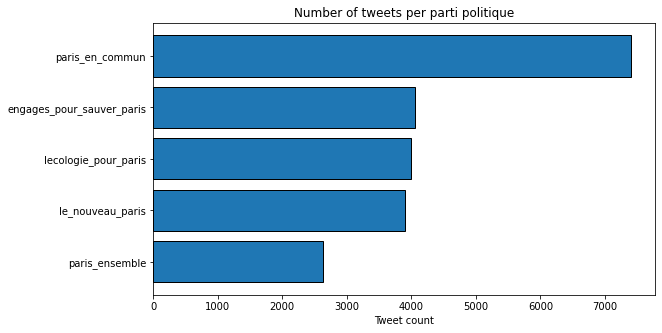

In [275]:
df_plot = pd.DataFrame.from_dict(Counter(tweet_predict["parti_politique"]), orient='index').reset_index().rename(columns={'index':'author', 0:'count'})
df_plot = df_plot.sort_values('count', ascending=True)
plt.figure(figsize=(9, 5))
plt.subplot(111)
plt.barh(df_plot["author"], df_plot["count"], linewidth = 1, edgecolor = "black")
plt.title("Number of tweets per parti politique")
plt.xlabel('Tweet count')
plt.show()

## **SVC original**

In [277]:
Xtest = tweet_predict['tweet_without_stopwords']
ytest = tweet_predict['parti_politique']

X_train, X_test, y_train, y_test = train_test_split(Xtest, ytest,test_size=0.20,random_state=123)

pipeline = Pipeline([("vect", CountVectorizer()),
                    ("chi", SelectKBest(chi2, k = 10000)),
                    ("clf", LinearSVC())])

model = pipeline.fit(X_train, y_train)
model_svc_original = model.score(X_test, y_test)
print("Accuracy of the original model:", model_svc_original)

prediction = model.predict(X_test)

clsf_report = pd.DataFrame(classification_report(y_true = y_test, y_pred = prediction, output_dict=True)).transpose()
clsf_report

Accuracy of the original model: 0.5734758871701547


precision    recall  f1-score      support
engages_pour_sauver_paris   0.588761  0.564259  0.576250   817.000000
le_nouveau_paris            0.608187  0.526582  0.564450   790.000000
lecologie_pour_paris        0.569273  0.527319  0.547493   787.000000
paris_en_commun             0.595264  0.719707  0.651597  1502.000000
paris_ensemble              0.385417  0.296000  0.334842   500.000000
accuracy                    0.573476  0.573476  0.573476     0.573476
macro avg                   0.549380  0.526774  0.534927  4396.000000
weighted avg                0.567857  0.573476  0.567268  4396.000000

## **SVC with TFI-DF vectorizer**

In [278]:
pipeline = Pipeline([("vect", TfidfVectorizer(ngram_range = (1, 1), sublinear_tf = True)),
                    ("chi", SelectKBest(chi2, k = 10000)),
                    ("clf", LinearSVC(C = 0.5, penalty = "l2", max_iter = 500, dual = False, random_state = 123))])
model = pipeline.fit(X_train, y_train)

model_svc_tfidf = model.score(X_test, y_test)
print("Accuracy of the hyperset model:", model_svc_tfidf)

prediction = model.predict(X_test)
print(classification_report(y_test, prediction))

Accuracy of the hyperset model: 0.6164695177434031
                           precision    recall  f1-score   support

engages_pour_sauver_paris       0.62      0.60      0.61       817
         le_nouveau_paris       0.67      0.59      0.63       790
     lecologie_pour_paris       0.64      0.58      0.61       787
          paris_en_commun       0.60      0.77      0.68      1502
           paris_ensemble       0.51      0.28      0.36       500

                 accuracy                           0.62      4396
                macro avg       0.61      0.56      0.58      4396
             weighted avg       0.61      0.62      0.61      4396



# **SGD**

In [279]:
Xtest = tweet_predict['tweet_without_stopwords']
ytest = tweet_predict['parti_politique']

X_train, X_test, y_train, y_test = train_test_split(Xtest, ytest,test_size=0.20,random_state=123)

pipeline = Pipeline([('vect', TfidfVectorizer(ngram_range=(1, 1), sublinear_tf = True)),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=50, tol=1e-3)),
                     ])

model = pipeline.fit(X_train, y_train)
model_sgd_tfidf = model.score(X_test, y_test)
print("Accuracy of the SGD model:", model_sgd_tfidf)

prediction = model.predict(X_test)
print(classification_report(y_test, prediction))

Accuracy of the SGD model: 0.6053230209281165
                           precision    recall  f1-score   support

engages_pour_sauver_paris       0.65      0.52      0.58       817
         le_nouveau_paris       0.66      0.55      0.60       790
     lecologie_pour_paris       0.62      0.57      0.59       787
          paris_en_commun       0.57      0.83      0.68      1502
           paris_ensemble       0.62      0.19      0.29       500

                 accuracy                           0.61      4396
                macro avg       0.62      0.53      0.55      4396
             weighted avg       0.62      0.61      0.59      4396



## **Logistic regression**

In [280]:
pipeline = Pipeline([("vect", TfidfVectorizer(ngram_range = (1, 1), sublinear_tf = True)),
                    ("chi", SelectKBest(chi2, k = 10000)),
                    ("clf", LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                                               intercept_scaling=1, max_iter=500, multi_class='auto', n_jobs=1,
                                               penalty='l2', random_state=123, solver='lbfgs', tol=0.0001,
                                               verbose=0, warm_start=False))])
model = pipeline.fit(X_train, y_train)
model_lr_tfidf = model.score(X_test, y_test)
print("Accuracy of the logistic regression model:", model_lr_tfidf)

prediction = model.predict(X_test)
print(classification_report(y_test, prediction))

Accuracy of the logistic regression model: 0.5971337579617835
                           precision    recall  f1-score   support

engages_pour_sauver_paris       0.62      0.54      0.58       817
         le_nouveau_paris       0.68      0.55      0.60       790
     lecologie_pour_paris       0.64      0.54      0.59       787
          paris_en_commun       0.56      0.82      0.66      1502
           paris_ensemble       0.52      0.20      0.29       500

                 accuracy                           0.60      4396
                macro avg       0.61      0.53      0.54      4396
             weighted avg       0.60      0.60      0.58      4396



## **Naives Bayes Classifier**

In [281]:
pipeline = Pipeline([("vect", TfidfVectorizer(ngram_range = (1, 1),  sublinear_tf = True)),
                    ("chi", SelectKBest(chi2, k = 10000)),
                    ("clf", MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])
model = pipeline.fit(X_train, y_train)
model_nb_tfidf = model.score(X_test, y_test)
print("Accuracy of the naive bayes model:", model_nb_tfidf)

prediction = model.predict(X_test)
print(classification_report(y_test, prediction))

Accuracy of the naive bayes model: 0.5532302092811647
                           precision    recall  f1-score   support

engages_pour_sauver_paris       0.76      0.35      0.47       817
         le_nouveau_paris       0.75      0.46      0.57       790
     lecologie_pour_paris       0.70      0.42      0.52       787
          paris_en_commun       0.47      0.95      0.63      1502
           paris_ensemble       1.00      0.05      0.09       500

                 accuracy                           0.55      4396
                macro avg       0.74      0.45      0.46      4396
             weighted avg       0.68      0.55      0.51      4396



## **Random Forest**

In [282]:
pipeline = Pipeline([("vect", TfidfVectorizer(ngram_range = (1, 1),  sublinear_tf = True)),
                    ("chi", SelectKBest(chi2, k = 10000)),
                    ("clf", RandomForestClassifier(n_estimators = 100))])

model = pipeline.fit(X_train, y_train)
model_randf_depth = model.score(X_test, y_test)
print("Accuracy of the random forest model:", model_randf_depth)

prediction = model.predict(X_test)
print(classification_report(y_test, prediction))

Accuracy of the random forest model: 0.5427661510464058
                           precision    recall  f1-score   support

engages_pour_sauver_paris       0.56      0.44      0.50       817
         le_nouveau_paris       0.64      0.44      0.52       790
     lecologie_pour_paris       0.59      0.46      0.52       787
          paris_en_commun       0.51      0.82      0.63      1502
           paris_ensemble       0.46      0.15      0.23       500

                 accuracy                           0.54      4396
                macro avg       0.55      0.46      0.48      4396
             weighted avg       0.55      0.54      0.52      4396



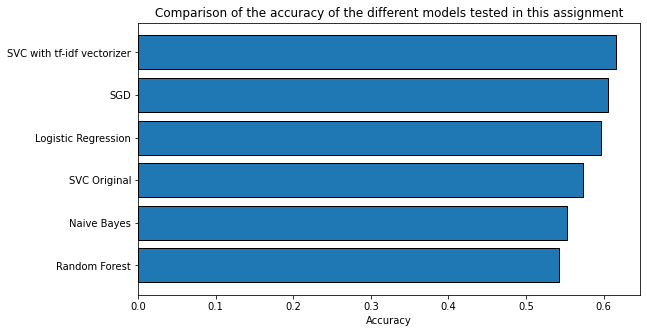

In [283]:
model_data = [("SVC Original", 0.5734758871701547),
              ("SVC with tf-idf vectorizer", 0.6164695177434031),
              ("SGD", 0.6053230209281165),
              ("Logistic Regression", 0.5971337579617835),
              ("Naive Bayes", 0.5532302092811647),
              ("Random Forest", 0.5427661510464058)]

model_label = ["Model", "Accuracy"]
df_model = pd.DataFrame.from_records(model_data, columns = model_label)
df_model = df_model.sort_values('Accuracy', ascending=True)

plt.figure(figsize=(9, 5))
plt.subplot(111)
plt.barh(df_model["Model"], df_model["Accuracy"], linewidth = 1, edgecolor = "black")
plt.title("Comparison of the accuracy of the different models tested in this assignment")
plt.xlabel('Accuracy')
plt.show()

## **Selected model : SVC with TFI-DF vectorizer**

In [284]:
pipeline = Pipeline([("vect", TfidfVectorizer(ngram_range = (1, 1), sublinear_tf = True)),
                    ("chi", SelectKBest(chi2, k = 10000)),
                    ("clf", LinearSVC(C = 0.5, penalty = "l2", max_iter = 500, dual = False, random_state = 123))])
model = pipeline.fit(X_train, y_train)

model_svc_tfidf = model.score(X_test, y_test)
print("Accuracy of the hyperset model:", model_svc_tfidf)

prediction = model.predict(X_test)
print(classification_report(y_test, prediction))

Accuracy of the hyperset model: 0.6164695177434031
                           precision    recall  f1-score   support

engages_pour_sauver_paris       0.62      0.60      0.61       817
         le_nouveau_paris       0.67      0.59      0.63       790
     lecologie_pour_paris       0.64      0.58      0.61       787
          paris_en_commun       0.60      0.77      0.68      1502
           paris_ensemble       0.51      0.28      0.36       500

                 accuracy                           0.62      4396
                macro avg       0.61      0.56      0.58      4396
             weighted avg       0.61      0.62      0.61      4396



## **Display the prediction results for each candidate**

In [0]:
#tweet_predict["parti_politique_predit"] = model.predict((tweet_predict["tweet_without_stopwords"]))
#tweet_predict

In [0]:
def pred(q):
    q_pred = model.predict(X_test)
    return q_pred

In [286]:
for i in range(20): 
  k = X_test.sample(1).index[0] 
  
  print("Cadidat: ", tweet_predict['candidat'][k], "\nPredicted party: ", pred(X_test[k])) 

  print("His real political party: ",tweet_predict["parti_politique"][k], "\n")

Cadidat:  jerome_coumet 
Predicted party:  ['le_nouveau_paris' 'engages_pour_sauver_paris' 'paris_en_commun' ...
 'engages_pour_sauver_paris' 'paris_en_commun' 'paris_ensemble']
His real political party:  paris_en_commun 

Cadidat:  rayan_nezzar 
Predicted party:  ['le_nouveau_paris' 'engages_pour_sauver_paris' 'paris_en_commun' ...
 'engages_pour_sauver_paris' 'paris_en_commun' 'paris_ensemble']
His real political party:  le_nouveau_paris 

Cadidat:  lucaselalouf1 
Predicted party:  ['le_nouveau_paris' 'engages_pour_sauver_paris' 'paris_en_commun' ...
 'engages_pour_sauver_paris' 'paris_en_commun' 'paris_ensemble']
His real political party:  le_nouveau_paris 

Cadidat:  francoisdagnaud 
Predicted party:  ['le_nouveau_paris' 'engages_pour_sauver_paris' 'paris_en_commun' ...
 'engages_pour_sauver_paris' 'paris_en_commun' 'paris_ensemble']
His real political party:  paris_en_commun 

Cadidat:  danlert 
Predicted party:  ['le_nouveau_paris' 'engages_pour_sauver_paris' 'paris_en_commun' ..